<a href="https://colab.research.google.com/github/pranay8297/deep-learning-projects/blob/master/benchmarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install tokenizers
!pip install nlp
!pip install rdkit
!pip install wandb
!pip install json
!pip install ipdb
!pip install deepchem
!pip install simpletransformers
!pip install torchmetrics
!pip install pytorch_metric_learning

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch
from ipdb import set_trace as st
import sklearn
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from torchmetrics import MeanAbsolutePercentageError

In [ ]:
from ipdb import set_trace as st

In [ ]:
import os

import numpy as np
import pandas as pd

from typing import List
from deepchem.molnet import load_bbbp, load_clearance, load_clintox, load_delaney, load_hiv, load_qm7, load_tox21
from rdkit import Chem
from transformers import RobertaTokenizerFast
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import json
from transformers import RobertaForMaskedLM
from transformers import PreTrainedModel, RobertaModel
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torch.utils.data import DataLoader
from pytorch_metric_learning import losses
from sklearn.metrics import roc_auc_score

In [ ]:
!ls

gdrive	sample_data


In [ ]:
!wget https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/vocab.txt

--2023-03-02 18:16:22--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/vocab.txt
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 52.219.112.201
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|52.219.112.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3524 (3.4K) [text/plain]
Saving to: ‘vocab.txt’

vocab.txt           100%[===================>]   3.44K  --.-KB/s    in 0s      

2023-03-02 18:16:22 (172 MB/s) - ‘vocab.txt’ saved [3524/3524]



In [ ]:
!cat vocab.txt

In [ ]:
!ls gdrive/MyDrive

In [ ]:
!mkdir gdrive/MyDrive/chem_datasets

mkdir: cannot create directory ‘gdrive/MyDrive/chem_datasets’: No such file or directory


In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
!ls

dataset-delaney.csv  gdrive  sample_data  vocab.txt


In [ ]:
!cp dataset-delaney.csv gdrive/MyDrive/chem_datasets/

In [ ]:
def split_df(df, train_pct = 0.8):
  split_idx = int(len(df) * train_pct)
  return df[:split_idx], df[split_idx:]

In [ ]:
!cp data_HLM_DOD.csv gdrive/MyDrive/chem_datasets
!cp data_PAMPA7_4.csv gdrive/MyDrive/chem_datasets
!cp data_PAMPA7_4_input.csv gdrive/MyDrive/chem_datasets
!cp smiles_cas_N6512_icmSmiles.csv gdrive/MyDrive/chem_datasets


cp: cannot stat 'data_HLM_DOD.csv': No such file or directory
cp: cannot stat 'data_PAMPA7_4.csv': No such file or directory
cp: cannot stat 'data_PAMPA7_4_input.csv': No such file or directory
cp: cannot stat 'smiles_cas_N6512_icmSmiles.csv': No such file or directory


In [ ]:
!ls gdrive/MyDrive/chem_datasets/

data_HLM_DOD.csv	 data_PgpInh_DOD_SALI_lt20_2191.csv
data_PAMPA7_4.csv	 dataset-delaney.csv
data_PAMPA7_4_input.csv  smiles_cas_N6512_icmSmiles.csv


In [ ]:
df_4 = pd.read_csv("gdrive/MyDrive/chem_datasets/dataset-delaney.csv")

In [ ]:
df_4.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [ ]:
df_4 = df_4[['measured log(solubility:mol/L)', 'SMILES']]

In [ ]:
df_4.head()

,measured log(solubility:mol/L),SMILES
0,-2.18,ClCC(Cl)(Cl)Cl
1,-2.00,CC(Cl)(Cl)Cl
2,-1.74,ClC(Cl)C(Cl)Cl
3,-1.48,ClCC(Cl)Cl
4,-3.04,FC(F)(Cl)C(F)(Cl)Cl


In [ ]:
df_4 = df_4.iloc[:, ::-1]

In [ ]:
df_4.head()

,SMILES,measured log(solubility:mol/L)
0,ClCC(Cl)(Cl)Cl,-2.18
1,CC(Cl)(Cl)Cl,-2.00
2,ClC(Cl)C(Cl)Cl,-1.74
3,ClCC(Cl)Cl,-1.48
4,FC(F)(Cl)C(F)(Cl)Cl,-3.04


In [ ]:
df_4['measured log(solubility:mol/L)'].describe()

count    1144.000000
mean       -3.057997
std         2.096502
min       -11.600000
25%        -4.332250
50%        -2.870500
75%        -1.600000
max         1.580000
Name: measured log(solubility:mol/L), dtype: float64

In [ ]:
df_4['sol'] = np.exp(df_4['measured log(solubility:mol/L)'])

In [ ]:
df_4['sol'].describe()

count    1144.000000
mean        0.235470
std         0.503060
min         0.000009
25%         0.013138
50%         0.056672
75%         0.201897
max         4.854956
Name: sol, dtype: float64

<AxesSubplot:>

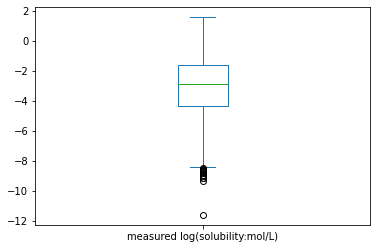

In [ ]:
df_4['measured log(solubility:mol/L)'].plot.box()

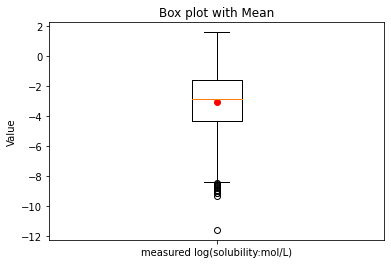

In [ ]:
means = [np.mean(df_4['measured log(solubility:mol/L)'])]
fig, ax = plt.subplots()
ax.boxplot(df_4['measured log(solubility:mol/L)'])
ax.scatter(np.arange(1, len(means) + 1), means, color='red', marker='o')
ax.set_xticklabels(['measured log(solubility:mol/L)'])
ax.set_ylabel('Value')
ax.set_title('Box plot with Mean')
plt.show()

<AxesSubplot:ylabel='Frequency'>

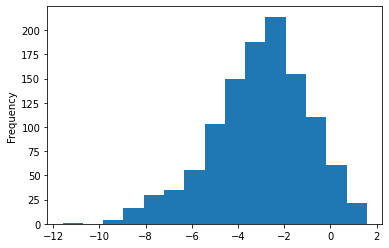

In [ ]:
df_4['measured log(solubility:mol/L)'].plot.hist(bins = 15)

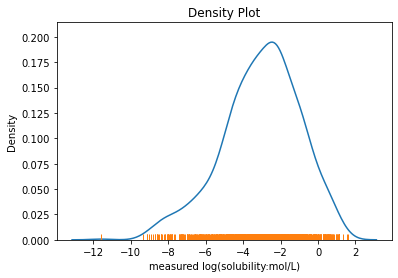

In [ ]:
sns.kdeplot(df_4['measured log(solubility:mol/L)'])
sns.rugplot(df_4['measured log(solubility:mol/L)'])
sns.set_style('whitegrid')
plt.xlabel('measured log(solubility:mol/L)')
plt.ylabel('Density')
plt.title('Density Plot')
plt.show()

In [ ]:
def get_len(x):
  return len(x)

df_4['SMILES_len'] = df_4['SMILES'].map(get_len)

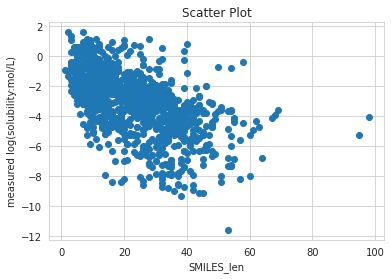

In [ ]:
x = df_4['SMILES_len']
y = df_4['measured log(solubility:mol/L)']

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_xlabel('SMILES_len')
ax.set_ylabel('measured log(solubility:mol/L)')
ax.set_title('Scatter Plot')
plt.show()

In [ ]:
df_4.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES,sol,SMILES_len
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl,0.113042,14
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl,0.135335,12
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl,0.175520,14
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl,0.227638,10
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl,0.047835,19


In [ ]:
df_4 = df_4[['SMILES', 'measured log(solubility:mol/L)']]
df_4 = df_4.sample(frac = 1).reset_index(drop = True)

train_df, valid_df = split_df(df_4, train_pct = 0.85)

In [ ]:
train_df.head()

,SMILES,measured log(solubility:mol/L)
0,O=C1N(C2CCC(=O)NC2=O)C(=O)c3ccccc13,-2.676
1,CNC(=O)Oc1ccccc1OC(C)C,-2.050
2,CCN(CC)c1nc(Cl)nc(n1)N(CC)CC,-4.411
3,NC(=O)NCc1ccccc1,-0.950
4,Cc1cc(C)c(C)cc1C,-4.590


In [ ]:
valid_df.head()

,SMILES,measured log(solubility:mol/L)
972,Nc1ncnc2nc[nH]c12,-2.120
973,CC(=O)OC3(CCC4C2C=C(C)C1=CC(=O)CCC1(C)C2CCC34C...,-5.350
974,Fc1ccccc1Br,-2.700
975,CCBr,-1.090
976,Cc1cc(cc(N(=O)=O)c1O)N(=O)=O,-1.456


In [ ]:
!ls gdrive/MyDrive/chem_datasets/

data_HLM_DOD.csv	 data_PgpInh_DOD_SALI_lt20_2191.csv
data_PAMPA7_4.csv	 dataset-delaney.csv
data_PAMPA7_4_input.csv  smiles_cas_N6512_icmSmiles.csv


,Name,mol,Activity_Pgp_inhibition,O_
0,pgpi0001,COc1cc(cc(c1OC)OC)C1=C(C(c2c(cc(cc2O1)O)O)=O)O,1,1
1,pgpi0002,CC(C)N=C1C=C2C(C=C1Nc1ccc(cc1)[Cl])=Nc1ccccc1N...,1,2
2,pgpi0003,CC(C)(C)c1ccc(cc1)[C@@H](CCCN1CCC(CC1)C(c1cccc...,1,3
3,pgpi0004,CC(C)[C@](CCCN(C)CCc1ccc(c(c1)OC)OC)(C#N)c1ccc...,1,4
4,pgpi0005,C1CN(CCN1CCOCCO)C1c2ccccc2Sc2ccccc2N=1,1,5


<AxesSubplot:xlabel='Activity_Pgp_inhibition'>

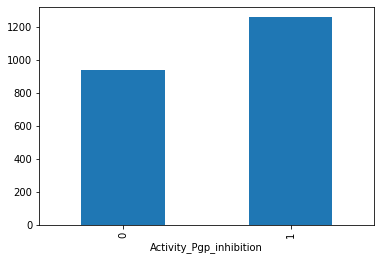

In [ ]:
!ls gdrive/MyDrive/chem_datasets

data_HLM_DOD.csv	 data_PgpInh_DOD_SALI_lt20_2191.csv
data_PAMPA7_4.csv	 smiles_cas_N6512_icmSmiles.csv
data_PAMPA7_4_input.csv


In [ ]:
df_3 = pd.read_csv('gdrive/MyDrive/chem_datasets/data_PAMPA7_4_input.csv')
df_3.head()

,PUBCHEM_SID,PUBCHEM_CID,SMILES_ISO,PUBCHEM_ACTIVITY_OUTCOME,Phenotype (0-10 = Low Permeability; 10-100 = Moderate Permeability; 100 = High Permeability),Permeability,Compound QC
0,24807327,15740787,C[N+]1=C2N(C3=CC=CC=C31)N=C(CS2)C4=CC=C(C=C4)O...,Inactive,Low,1.0,QC'ed NCATS
1,144203564,79472,CC1=CC(=C2C=C(C=CC2=N1)NC(=O)NC3=CC4=C(C=C(N=C...,Inactive,Low,1.0,QC'ed NCATS
2,124877612,3246218,C1=NC(=C2C(=N1)N(C=N2)[C@H]3[C@H]([C@H]([C@@H]...,Inactive,Low,1.0,QC'ed NCATS
3,124879938,5281708,C1=CC(=CC=C1C2=COC3=C(C2=O)C=CC(=C3)O)O,Inactive,Low,1.0,QC'ed NCATS
4,124881727,5353685,COC1=C(C(=CC(=C1)/C=C(\C#N)/C(=O)C2=CC(=C(C=C2...,Inactive,Low,1.0,QC'ed NCATS


In [ ]:
df_3 = df_3[['SMILES_ISO', 'Permeability']]
df_3 = df_3.sample(frac=1).reset_index(drop=True)


In [ ]:
df_3.head()

,SMILES_ISO,Permeability
0,C1=CC=C2C(=C1)N=C(N2/N=C/C3=CC=C(S3)[N+](=O)[O...,268.59
1,COC1=CC=CC(=C1O)CNC2=CC=C(C=C2)S(=O)(=O)NC3=CC...,571.62
2,C1=CC=C(C(=C1)CNC2=CC=C(C=C2)O)OCC3=CC=CC=C3Cl,79.50
3,CC1=C(C(=CC=C1)N2CCN(CC2)C(=O)CN3C4=C(COC5=CC=...,675.79
4,CC1=CC(=C(N1C2=CN=CC=C2)C)C3=NN=C4N3CCCCC4,49.20


<AxesSubplot:>

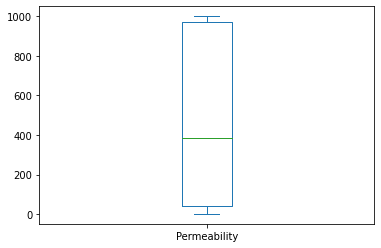

In [ ]:
df_3['Permeability'].plot.box()

In [ ]:
df_3['permeability_log'] = np.log(df_3['Permeability'])

<AxesSubplot:>

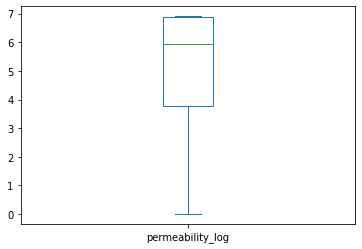

In [ ]:
df_3['permeability_log'].plot.box()

In [ ]:
np.min(df_3['permeability_log']), np.max(df_3['permeability_log'])

(0.0, 6.907755278982137)

<AxesSubplot:ylabel='Frequency'>

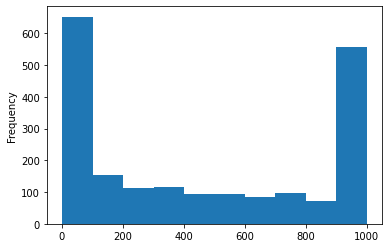

In [ ]:
df_3['Permeability'].plot.hist()

In [ ]:
train_df_3, valid_df_3 = split_df(df_3, train_pct = 0.85)

In [ ]:
train_df , valid_df = train_df_3, valid_df_3

,Name,mol,Activity_Pgp_inhibition,O_
0,pgpi0001,COc1cc(cc(c1OC)OC)C1=C(C(c2c(cc(cc2O1)O)O)=O)O,1,1
1,pgpi0002,CC(C)N=C1C=C2C(C=C1Nc1ccc(cc1)[Cl])=Nc1ccccc1N...,1,2
2,pgpi0003,CC(C)(C)c1ccc(cc1)[C@@H](CCCN1CCC(CC1)C(c1cccc...,1,3
3,pgpi0004,CC(C)[C@](CCCN(C)CCc1ccc(c(c1)OC)OC)(C#N)c1ccc...,1,4
4,pgpi0005,C1CN(CCN1CCOCCO)C1c2ccccc2Sc2ccccc2N=1,1,5


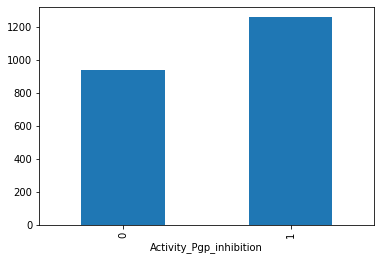

In [ ]:
df_2 = pd.read_csv('gdrive/MyDrive/chem_datasets/data_PgpInh_DOD_SALI_lt20_2191.csv')
df_2.groupby(['Activity_Pgp_inhibition']).size().plot.bar()
df_2.head()

In [ ]:
df_2 = df_2[['mol', 'Activity_Pgp_inhibition']]

In [ ]:
df_2 = df_2.sample(frac=1).reset_index(drop=True)

In [ ]:
df_2.head()

,mol,Activity_Pgp_inhibition
0,CCCN(Cc1ccccc1)C[C@H](COc1ccccc1C(CCc1ccccc1)=O)O,1
1,C1CCN(C1)CCN1C(c2cccc3cc(cc(C1=O)c23)[N+]([O-]...,0
2,COc1ccc2c(c1)N(C(N(CCOC(Nc1ccccc1)=O)CCOC(Nc1c...,1
3,C1CC[C@H]([C@H](C1)N1CCN(CC1)c1ccccc1)NC(c1ccc...,1
4,CN(C)[C@@H]1C(C(=C(N)O)C([C@@]2(C(C3=C(c4c(ccc...,0


In [ ]:
train_df_2, valid_df_2 = split_df(df_2, train_pct = 0.85)

In [ ]:
df_1 = pd.read_csv('gdrive/MyDrive/chem_datasets/data_HLM_DOD.csv')

In [ ]:
df_1.groupby(['Property']).size()

Property
0    2053
1    1166
dtype: int64

In [ ]:
df_1 = df_1[['Smiles', 'Property']]

In [ ]:
df_1.columns

Index(['Smiles', 'Property'], dtype='object')

In [ ]:
df_1 = df_1.sample(frac=1).reset_index(drop=True)

In [ ]:
df_1.head()

,Smiles,Property
0,CC(C)CCN1N2CCCC2C(=C(C1=O)C3=NS(=O)(=O)c4cc(NS...,0
1,CNc1nc(NCCCN(C)C)c2sc(cc2n1)c3cocc3,0
2,FC1(F)CCC(CC1)[C@H](NC(=O)c2ccsc2)c3cn(nn3)C4(...,1
3,COc1ccc(cc1)[C@H]2CN(NS(=O)(=O)C)C(=O)N2CCc3cc...,1
4,COc1cccc(\C=N\N(C(=O)C(F)(F)F)c2ccc(C)cc2C)c1,1


In [ ]:
df = pd.read_csv('gdrive/MyDrive/dataset_files/mutagency.csv')

In [ ]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.head()

,smiles,mutagenicity
0,CCCCN(CCCO)N=O,1
1,c1(c(c(c(c(c1[Cl])[Cl])[Cl])[Cl])[Cl])[N+]([O-...,0
2,CCCCC(CC)COC(c1ccc(cc1)C(O)=O)=O,0
3,c1ccc2c(c1)c1ccc3c(ccc4ccc(c1c34)n2)[N+]([O-])=O,1
4,Cc1cc2c(C)cc(C)nc2cc1N,1


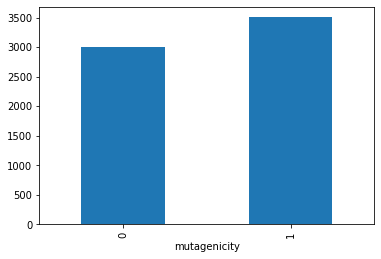

In [ ]:
df.groupby(['mutagenicity']).size().plot.bar()

In [ ]:
train_df, valid_df = split_df(df)

In [ ]:
train_df_1, valid_df_1 = split_df(df_1)

In [ ]:
valid_df.head()

,smiles,mutagenicity
5209,CCN(CCCNc1c2ccccc2nc2c(cccc12)OC)CC[Cl],1
5210,C(CC(O)=O)C(C(O)=O)NC(COc1cc(c(cc1[Cl])[Cl])[C...,0
5211,C(c1ccc(cc1)F)n1c2ccc(cc2nc1/C=N/OCc1cccc(c1)[...,0
5212,c1ccc2c(c1)cc1cc(ccc1n2)N,1
5213,C1[C@@H]([C@H]([C@H]([C@H](N(c2ccc(cc2)[N+]([O...,1


In [ ]:
from simpletransformers.classification import ClassificationModel
import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import threading
from queue import Queue
class MultiThreadedTrainer():
  def __init__(self, model, save_model_loc = '/content/BPE_PubChem_10M_ClinTox_run', train_df = train_df, eval_df = valid_df, project_name = "roberta"):
    self.lock = threading.Lock()
    self.model = model
    self.save_model_loc = save_model_loc

    self.train_df = train_df
    self.eval_df = eval_df
    self.project_name = project_name
    
  
  def train_model_with_lock(self):

    with self.lock:
      # train_model(train_df, eval_df = valid_df, output_dir='/content/simple_transformer_saved_models/')
      self.model.train_model(self.train_df, eval_df = self.eval_df, output_dir = self.save_model_loc, args = {"overwrite_output_dir": True})

    return 
  
  def train(self, n_threads = 1):
    threads = []
    
    # for i in range(n_threads):

    t = threading.Thread(target = self.train_model_with_lock)
    threads.append(t)

    for t in threads:
      t.start()
    
    for t in threads:
      t.join()

    return 
  
  def eval_model_with_lock(self):
    # st()
    with self.lock:
      outs = self.model.eval_model(self.eval_df, acc=sklearn.metrics.accuracy_score)
    
    # with self.lock:
    #   outs_2 = self.model.eval_model(test_df, acc=sklearn.metrics.average_precision_score)
    
    self.output_queue.put({"acc": outs})
    return outs
  
  def eval(self):

    self.output_queue = Queue()
    t = threading.Thread(target = self.eval_model_with_lock)
    t.start()
    t.join()

    outputs = []

    while not self.output_queue.empty():
      output = self.output_queue.get()
      outputs.append(output)

    return outputs


In [ ]:
model, Trainer = None, None

In [ ]:
model = ClassificationModel('roberta', 'seyonec/PubChem10M_SMILES_BPE_396_250', args={'evaluate_each_epoch': True, 'evaluate_during_training_verbose': True, 'no_save': True, 'num_train_epochs': 6, 'auto_weights': True}) # You can set class weights by using the optional weight argument

SyntaxError: ignored

In [ ]:
model.model, model.tokenizer

In [ ]:
!mkdir simple_transformer_saved_models

In [ ]:
Trainer = MultiThreadedTrainer(model, save_model_loc = '/content/simple_transformer_saved_models', train_df = train_df, eval_df = valid_df)

In [ ]:
Trainer.train(n_threads = 1)

/usr/local/lib/python3.8/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/5209 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/652 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/652 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/652 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/652 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/652 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/652 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/652 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/652 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/652 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/652 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/652 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/652 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/652 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/652 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/652 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/652 [00:00<?, ?it/s]

  0%|          | 0/5209 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/652 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/652 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/652 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/652 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/652 [00:00<?, ?it/s]

In [ ]:
model = Trainer.model

In [ ]:
res = Trainer.eval()
# result, model_outputs, wrong_prediction

/usr/local/lib/python3.8/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1303 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/163 [00:00<?, ?it/s]

In [ ]:
result, model_outputs, wrong_prediction = res[0]['acc']

In [ ]:
result

{'mcc': 0.572664574424083,
 'tp': 540,
 'tn': 485,
 'fp': 145,
 'fn': 133,
 'auroc': 0.8569081817967406,
 'auprc': 0.8477712980444738,
 'acc': 0.7866462010744436,
 'eval_loss': 1.7476756252759804}

In [ ]:
model_outputs

array([[-5.984375  ,  6.0234375 ],
       [ 5.72265625, -5.60546875],
       [ 4.79296875, -4.5234375 ],
       ...,
       [-5.11328125,  4.9296875 ],
       [ 2.40625   , -2.3671875 ],
       [-4.51953125,  4.50390625]])

In [ ]:
model_1 = ClassificationModel('roberta', 'seyonec/PubChem10M_SMILES_BPE_396_250', args={'evaluate_each_epoch': True, 'evaluate_during_training_verbose': True, 'no_save': True, 'num_train_epochs': 6, 'auto_weights': True}) # You can set class weights by using the optional weight argument
Trainer_1 = MultiThreadedTrainer(model_1, save_model_loc = '/content/simple_transformer_saved_models', train_df = train_df_1, eval_df = valid_df_1)

Some weights of the model checkpoint at seyonec/PubChem10M_SMILES_BPE_396_250 were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/PubChem10M_SMILES_BPE

In [ ]:
Trainer_1.train(n_threads = 1)

/usr/local/lib/python3.8/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/2575 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/322 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/322 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/322 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/322 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/322 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/322 [00:00<?, ?it/s]

In [ ]:
result_1, model_outputs_1, wrong_prediction_1 = Trainer_1.eval()[0]['acc']

/usr/local/lib/python3.8/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/644 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
result_1

{'mcc': 0.5644618153628217,
 'tp': 162,
 'tn': 353,
 'fp': 50,
 'fn': 79,
 'auroc': 0.8565324382484066,
 'auprc': 0.7913296290088063,
 'acc': 0.7996894409937888,
 'eval_loss': 0.8884100575505951}

In [ ]:
model_2 = ClassificationModel('roberta', 'seyonec/PubChem10M_SMILES_BPE_396_250', args={'evaluate_each_epoch': True, 'evaluate_during_training_verbose': True, 'no_save': True, 'num_train_epochs': 8, 'auto_weights': True}) # You can set class weights by using the optional weight argument
Trainer_2 = MultiThreadedTrainer(model_2, save_model_loc = '/content/simple_transformer_saved_models', train_df = train_df_2, eval_df = valid_df_2)

Some weights of the model checkpoint at seyonec/PubChem10M_SMILES_BPE_396_250 were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/PubChem10M_SMILES_BPE

In [ ]:
Trainer_2.train()

  0%|          | 0/1862 [00:00<?, ?it/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/233 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/233 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/233 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/233 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/233 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/233 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/233 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/233 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/1862 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/233 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/233 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/233 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/233 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/233 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/233 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/233 [00:00<?, ?it/s]

In [ ]:
result_2, model_outputs_2, wrong_prediction_2 = Trainer_2.eval()[0]['acc']

/usr/local/lib/python3.8/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/329 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/42 [00:00<?, ?it/s]

In [ ]:
result_2

{'mcc': 0.7761202776489946,
 'tp': 175,
 'tn': 118,
 'fp': 23,
 'fn': 13,
 'auroc': 0.9479025199939641,
 'auprc': 0.950879135198782,
 'acc': 0.8905775075987842,
 'eval_loss': 0.6104427356095541}

In [ ]:
model_args = ClassificationArgs()

model_args.regression = True
model_args.evaluate_each_epoch = True
model_args.num_train_epochs = 8
model_args.auto_weights = True

In [ ]:
model_3 = ClassificationModel('roberta', 'seyonec/PubChem10M_SMILES_BPE_396_250', args = model_args)
Trainer_3 = MultiThreadedTrainer(model_3, save_model_loc = '/content/simple_transformer_saved_models', train_df = train_df_3, eval_df = valid_df_3)

Some weights of the model checkpoint at seyonec/PubChem10M_SMILES_BPE_396_250 were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/PubChem10M_SMILES_BPE

In [ ]:
model_3.model.roberta.embeddings, 

RobertaEmbeddings(
  (word_embeddings): Embedding(52000, 768, padding_idx=1)
  (position_embeddings): Embedding(512, 768, padding_idx=1)
  (token_type_embeddings): Embedding(1, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
Trainer_3.train(n_threads = 1)

In [ ]:
df_3.head()

,SMILES_ISO,Permeability
0,CC1=CC(=NC=C1)NC(=S)N2CCN(CC2)C3=C(C=C(C=C3)Cl)Cl,867.73
1,CC1=CC=C(C=C1)S(=O)(=O)NC2=C(C=CN=C2)C(=O)NC3=...,46.01
2,CCOC(=O)N1CCN(CC1)CC2=NC3=C(N2CC4=CC=CC(=C4)C)...,476.86
3,CC1=C(C=C(C=C1)NS(=O)(=O)C2=C(NC(=C2C(=O)N3CCC...,387.03
4,CCCCCCC.CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CN3,713.65


In [ ]:
df_4.columns

Index(['SMILES', 'measured log(solubility:mol/L)'], dtype='object')

In [ ]:
smiles_tokenizer = RobertaTokenizerFast.from_pretrained("seyonec/SMILES_tokenized_PubChem_shard00_160k", max_len = 512)
class RegressionDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer = smiles_tokenizer):
        self.df = df
        self.labels = [label for label in df['measured log(solubility:mol/L)']]
        self.texts = [tokenizer(text, padding='max_length', max_length = 512, truncation=True, return_tensors="pt") for text in df['SMILES']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
class ClassificationDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer = smiles_tokenizer):
        self.df = df
        cols = df.columns
        self.labels = [label for label in df[cols[-1]]]
        self.texts = [tokenizer(text, padding='max_length', max_length = 512, truncation=True, return_tensors="pt") for text in df[cols[-2]]]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
ds_2 = ClassificationDataset(df_2)

In [ ]:
ds = RegressionDataset(df_4, smiles_tokenizer)

In [ ]:
ds[1]

In [ ]:
max(df_3['Permeability']), min(df_3['Permeability'])

(1000.0, 1.0)

In [ ]:
train_ds, valid_ds = RegressionDataset(train_df, smiles_tokenizer), RegressionDataset(valid_df, smiles_tokenizer)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size = 32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(valid_ds, batch_size = 32)

In [ ]:
train_ds_2, valid_ds_2 = ClassificationDataset(train_df_2, smiles_tokenizer), ClassificationDataset(valid_df_2, smiles_tokenizer)
train_dataloader_2 = torch.utils.data.DataLoader(train_ds_2, batch_size = 32, shuffle=True)
val_dataloader_2 = torch.utils.data.DataLoader(valid_ds_2, batch_size = 32, shuffle=True)

In [ ]:
x, y = next(iter(train_dataloader_2))

In [ ]:
x['input_ids'].shape, y.shape

(torch.Size([32, 1, 512]), torch.Size([32]))

In [ ]:
x, y = next(iter(train_dataloader))

In [ ]:
y

tensor([-4.8050, -3.0910, -4.0990, -4.4110,  0.1500,  0.6100, -2.7000, -6.1440,
        -3.4200, -3.7000,  0.1500,  0.4900, -2.1680, -3.0100, -2.5400, -2.5800,
        -1.8500, -7.8000, -0.5900, -3.2200, -1.1700, -1.4700, -1.5200, -1.6800,
        -2.5900, -6.6800, -3.1700, -5.6400, -0.9720, -2.5300, -3.6800, -1.1600],
       dtype=torch.float64)

In [ ]:
class RegressionHead(nn.Module):

  def __init__(self, in_features = 768, out_features = 1, dropout_prob = 0.1):
    super().__init__()
    self.dense = nn.Linear(in_features, in_features)
    self.dropout = nn.Dropout(dropout_prob)
    self.out_proj = nn.Linear(in_features, out_features)

  def forward(self, x, **kwargs):
    # x = features[:, 0, :]  # take <s> token (equiv. to [CLS])
    x = self.dropout(x)
    x = self.dense(x)
    x = torch.relu(x)
    x = self.dropout(x)
    x = self.out_proj(x)
    return x
  
class RegressionModel(nn.Module):

  def __init__(self, base_model = None, high =0, low = 1):
    super().__init__()
    if not base_model:
      base_model = ClassificationModel('roberta', 'seyonec/PubChem10M_SMILES_BPE_396_250', args = {})
    
    self.embs = base_model.model.roberta.embeddings
    self.encoder = base_model.model.roberta.encoder

    # self.regression_layer = nn.Sequential(
    #     nn.Linear(in_features=768, out_features=768, bias=True),
    #     nn.BatchNorm1d(768),
    #     nn.ReLU(),
    #     nn.Dropout(p=0.1, inplace=False),
    #     nn.Linear(in_features=768, out_features=1, bias=True)
    # )
    self.regression_layer = RegressionHead()
    self.high, self.low = (high, low)
    self.freeze_status = {'embs': False, 'encoder': False, "regression_layer": False}
  
  def forward(self, x):

    inp = self.embs(x)[:, 0, :, :]
    attns = self.encoder(inp)
    # st()
    yhat = self.regression_layer(attns.last_hidden_state[:, 0, :])
  
    return torch.sigmoid(yhat) * (self.high - self.low) + self.low
  
  def freeze_unfreeze_layers(self, module_to_freeze = 'encoder', action = 'freeze'):

    layers_to_freeze = self.encoder
    if (module_to_freeze == 'embs'):
      layers_to_freeze = self.embs
    elif(module_to_freeze == 'regression_layer'):
      layers_to_freeze = self.regression_layer
    
    requires_grad_to_set = False
    if (action == 'unfreeze'):
      requires_grad_to_set = True

    for param in layers_to_freeze.parameters():
      param.requires_grad = requires_grad_to_set

    self.freeze_status[module_to_freeze] = (not requires_grad_to_set)


In [ ]:
not True

False

Some weights of the model checkpoint at seyonec/PubChem10M_SMILES_BPE_396_250 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/PubChem10M_SMILES_BPE

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import gc
reg_model = None
gc.collect()

88

In [ ]:
yhat = reg_model(x['input_ids'])

In [ ]:
yhat.shape

torch.Size([32, 1])

In [ ]:
yhat

In [ ]:
m1 = RegressionModel()
m2 = RegressionModel()

Some weights of the model checkpoint at seyonec/PubChem10M_SMILES_BPE_396_250 were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/PubChem10M_SMILES_BPE

In [ ]:
# Verification on weather the model is same pretrained or not
for i, j in zip(m1.parameters(), m2.parameters()):
  # torch.sum((attn_op[0, :, :, :] == attn_op[0, :, :, :]).int())
  print(torch.sum((i == j).int()))

In [ ]:
y.dtype

torch.float64

In [ ]:
reg_model = RegressionModel()
reg_model.freeze_unfreeze_layers()

Some weights of the model checkpoint at seyonec/PubChem10M_SMILES_BPE_396_250 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/PubChem10M_SMILES_BPE

In [ ]:
model = reg_model
model = model.to(device)

In [ ]:
train_df , valid_df = None, None
val_dataloader, train_dataloader = None, None
learning_rate = 1e-06,


In [ ]:
from torch.optim import Adam
from tqdm import tqdm

def train_regression(model, train_dataloader, val_dataloader, learning_rate, epochs, train_data = train_df, val_data = valid_df, wd = 1e-02):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr = learning_rate, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 7e-06, steps_per_epoch = len(train_dataloader), epochs = epochs)
    mean_abs_percentage_error = MeanAbsolutePercentageError()

    if use_cuda:
            # model = model.cuda()
            criterion = criterion.cuda()
            mean_abs_percentage_error = mean_abs_percentage_error.cuda()

    def mape(yhat, y, mean_abs_percentage_error = mean_abs_percentage_error):

        # yhat = torch.exp(yhat)
        # y = torch.exp(y)
        error = mean_abs_percentage_error(yhat, y)

        return (1 - error)
        
    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = []

            for train_input, train_label in tqdm(train_dataloader):

                mask = train_input['attention_mask']
                input_id = train_input['input_ids']
                train_label = train_label.float()

                if(input_id.shape[0] != 32):
                    continue
                
                if use_cuda:
                    # mask = mask.to(device)
                    input_id = input_id.to(device)
                    train_label = train_label.to(device)
                
                # st()
                output = model(input_id).squeeze()
                
                batch_loss = criterion(output, train_label)
                # print(batch_loss)
                total_loss_train.append(batch_loss.item())
                
                acc = mape(output, train_label)
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
                scheduler.step()
            
            total_acc_val = 0
            total_loss_val = []

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.float()
                    val_label = val_label.to(device)
                    # mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].to(device)

                    if(input_id.shape[0] != 32):
                        continue

                    output = model(input_id).squeeze()

                    batch_loss = criterion(output, val_label)
                    total_loss_val.append(batch_loss.item())
                    
                    acc = mape(output, val_label)
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {np.mean(total_loss_train): .3f} \
                | Val Loss: {np.mean(total_loss_val): .3f} \
                | Train Acc: {total_acc_train/len(train_data): .3f} \
                | Val Acc: {total_acc_val/len(val_data): .3f}')
                  


In [ ]:
EPOCHS = 5
LR = 1e-4
       
train_regression(model, train_dataloader, val_dataloader, LR, EPOCHS)

100%|██████████| 31/31 [00:07<00:00,  3.88it/s]


Epochs: 1 | Train Loss:  6.934                 | Val Loss:  7.460                 | Train Acc: -256.569                 | Val Acc: -0.117


100%|██████████| 31/31 [00:07<00:00,  3.90it/s]


Epochs: 2 | Train Loss:  4.519                 | Val Loss:  5.551                 | Train Acc: -179.057                 | Val Acc: -0.072


100%|██████████| 31/31 [00:07<00:00,  3.91it/s]


Epochs: 3 | Train Loss:  4.338                 | Val Loss:  5.270                 | Train Acc: -170.054                 | Val Acc: -0.072


100%|██████████| 31/31 [00:07<00:00,  3.91it/s]


Epochs: 4 | Train Loss:  4.219                 | Val Loss:  5.615                 | Train Acc: -176.460                 | Val Acc: -0.077


100%|██████████| 31/31 [00:07<00:00,  3.91it/s]


Epochs: 5 | Train Loss:  4.276                 | Val Loss:  5.766                 | Train Acc: -180.179                 | Val Acc: -0.080


In [ ]:
model.freeze_unfreeze_layers('encoder', action = 'unfreeze')

In [ ]:
EPOCHS = 10
LR = 1e-6
       
train_regression(model, train_dataloader, val_dataloader, LR, EPOCHS)

100%|██████████| 31/31 [00:10<00:00,  2.85it/s]


Epochs: 1 | Train Loss:  4.316                 | Val Loss:  5.311                 | Train Acc: -180.193                 | Val Acc: -0.070


100%|██████████| 31/31 [00:10<00:00,  2.86it/s]


Epochs: 2 | Train Loss:  3.700                 | Val Loss:  3.856                 | Train Acc: -142.443                 | Val Acc: -0.076


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  3.073                 | Val Loss:  3.190                 | Train Acc: -93.067                 | Val Acc: -0.037


100%|██████████| 31/31 [00:10<00:00,  2.86it/s]


Epochs: 4 | Train Loss:  2.728                 | Val Loss:  2.647                 | Train Acc: -124.444                 | Val Acc: -0.036


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Epochs: 5 | Train Loss:  2.566                 | Val Loss:  2.573                 | Train Acc: -98.589                 | Val Acc: -0.024


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Epochs: 6 | Train Loss:  2.452                 | Val Loss:  2.245                 | Train Acc: -76.334                 | Val Acc: -0.034


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Epochs: 7 | Train Loss:  2.014                 | Val Loss:  2.037                 | Train Acc: -93.814                 | Val Acc: -0.027


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Epochs: 8 | Train Loss:  1.870                 | Val Loss:  1.751                 | Train Acc: -86.135                 | Val Acc: -0.023


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Epochs: 9 | Train Loss:  1.797                 | Val Loss:  1.909                 | Train Acc: -97.946                 | Val Acc: -0.027


100%|██████████| 31/31 [00:10<00:00,  2.86it/s]


Epochs: 10 | Train Loss:  1.771                 | Val Loss:  1.809                 | Train Acc: -89.609                 | Val Acc: -0.027


In [ ]:
EPOCHS = 15
LR = 6e-7
       
train_regression(model, train_dataloader, val_dataloader, LR, EPOCHS)

100%|██████████| 31/31 [00:10<00:00,  2.86it/s]


Epochs: 1 | Train Loss:  1.705                 | Val Loss:  1.735                 | Train Acc: -93.623                 | Val Acc: -0.026


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Epochs: 2 | Train Loss:  1.712                 | Val Loss:  1.836                 | Train Acc: -92.970                 | Val Acc: -0.014


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  1.771                 | Val Loss:  1.559                 | Train Acc: -123.121                 | Val Acc: -0.009


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Epochs: 4 | Train Loss:  1.532                 | Val Loss:  1.518                 | Train Acc: -62.543                 | Val Acc: -0.006


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Epochs: 5 | Train Loss:  1.225                 | Val Loss:  1.011                 | Train Acc: -44.517                 | Val Acc: -0.014


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Epochs: 6 | Train Loss:  1.126                 | Val Loss:  1.008                 | Train Acc: -50.974                 | Val Acc: -0.009


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Epochs: 7 | Train Loss:  0.920                 | Val Loss:  0.849                 | Train Acc: -28.351                 | Val Acc:  0.004


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Epochs: 8 | Train Loss:  0.866                 | Val Loss:  0.848                 | Train Acc: -22.012                 | Val Acc: -0.004


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Epochs: 9 | Train Loss:  0.828                 | Val Loss:  0.786                 | Train Acc: -24.677                 | Val Acc: -0.002


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Epochs: 10 | Train Loss:  0.822                 | Val Loss:  0.817                 | Train Acc: -24.982                 | Val Acc: -0.005


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Epochs: 11 | Train Loss:  0.780                 | Val Loss:  0.792                 | Train Acc: -18.717                 | Val Acc:  0.002


100%|██████████| 31/31 [00:10<00:00,  2.86it/s]


Epochs: 12 | Train Loss:  0.750                 | Val Loss:  0.731                 | Train Acc: -25.066                 | Val Acc:  0.005


100%|██████████| 31/31 [00:10<00:00,  2.86it/s]


Epochs: 13 | Train Loss:  0.750                 | Val Loss:  0.769                 | Train Acc: -2.799                 | Val Acc:  0.002


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Epochs: 14 | Train Loss:  0.784                 | Val Loss:  0.729                 | Train Acc: -24.826                 | Val Acc:  0.004


100%|██████████| 31/31 [00:10<00:00,  2.86it/s]


Epochs: 15 | Train Loss:  0.725                 | Val Loss:  0.695                 | Train Acc: -16.107                 | Val Acc: -0.002


In [ ]:
EPOCHS = 1
LR = 1e-5
       
train_regression(model, train_dataloader, val_dataloader, LR, EPOCHS)

100%|██████████| 31/31 [00:10<00:00,  2.85it/s]


Epochs: 1 | Train Loss:  0.814                 | Val Loss:  0.775                 | Train Acc: -31.374                 | Val Acc:  0.005


In [ ]:
EPOCHS = 15
LR = 4e-7
       
train_regression(model, train_dataloader, val_dataloader, LR, EPOCHS)

100%|██████████| 31/31 [00:10<00:00,  2.85it/s]


Epochs: 1 | Train Loss:  0.759                 | Val Loss:  0.694                 | Train Acc: -25.497                 | Val Acc:  0.003


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Epochs: 2 | Train Loss:  0.761                 | Val Loss:  0.876                 | Train Acc: -21.781                 | Val Acc: -0.004


100%|██████████| 31/31 [00:10<00:00,  2.86it/s]


Epochs: 3 | Train Loss:  0.750                 | Val Loss:  0.731                 | Train Acc: -20.904                 | Val Acc:  0.008


100%|██████████| 31/31 [00:10<00:00,  2.86it/s]


Epochs: 4 | Train Loss:  0.841                 | Val Loss:  0.795                 | Train Acc: -10.813                 | Val Acc:  0.002


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Epochs: 5 | Train Loss:  0.833                 | Val Loss:  0.741                 | Train Acc: -0.595                 | Val Acc: -0.006


100%|██████████| 31/31 [00:10<00:00,  2.86it/s]


Epochs: 6 | Train Loss:  0.810                 | Val Loss:  0.835                 | Train Acc: -28.297                 | Val Acc:  0.004


100%|██████████| 31/31 [00:10<00:00,  2.86it/s]


Epochs: 7 | Train Loss:  0.874                 | Val Loss:  0.723                 | Train Acc: -27.209                 | Val Acc: -0.003


100%|██████████| 31/31 [00:10<00:00,  2.86it/s]


Epochs: 8 | Train Loss:  0.740                 | Val Loss:  0.701                 | Train Acc: -15.082                 | Val Acc: -0.001


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Epochs: 9 | Train Loss:  0.723                 | Val Loss:  0.688                 | Train Acc: -18.797                 | Val Acc:  0.002


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Epochs: 10 | Train Loss:  0.726                 | Val Loss:  0.830                 | Train Acc: -13.620                 | Val Acc:  0.001


100%|██████████| 31/31 [00:10<00:00,  2.86it/s]


Epochs: 11 | Train Loss:  0.800                 | Val Loss:  0.791                 | Train Acc: -22.498                 | Val Acc: -0.002


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Epochs: 12 | Train Loss:  0.663                 | Val Loss:  0.618                 | Train Acc: -20.713                 | Val Acc:  0.001


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Epochs: 13 | Train Loss:  0.689                 | Val Loss:  0.661                 | Train Acc: -15.326                 | Val Acc:  0.001


100%|██████████| 31/31 [00:10<00:00,  2.87it/s]


Epochs: 14 | Train Loss:  0.629                 | Val Loss:  0.615                 | Train Acc: -16.512                 | Val Acc:  0.003


100%|██████████| 31/31 [00:10<00:00,  2.86it/s]


Epochs: 15 | Train Loss:  0.642                 | Val Loss:  0.664                 | Train Acc: -13.670                 | Val Acc:  0.004


In [ ]:
x, y = next(iter(val_dataloader))

In [ ]:
x = x['input_ids']

In [ ]:
x = x.to(device)
y = y.to(device)

In [ ]:
yhat = model(x)

In [ ]:
yhat = yhat.squeeze()

In [ ]:
torch.mean(torch.abs(y - yhat)/torch.abs(y))

tensor(0.4282, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
torch.abs(y)

tensor([2.1200, 5.3500, 2.7000, 1.0900, 1.4560, 4.1600, 3.3800, 0.5100, 4.1000,
        2.0500, 1.2800, 1.9600, 8.1760, 2.5100, 1.6000, 0.4600, 3.2100, 4.4700,
        0.9850, 2.3370, 0.8000, 2.2660, 2.8200, 2.3700, 1.1100, 8.0030, 2.2900,
        3.0500, 2.0900, 1.1900, 2.3900, 2.6170], device='cuda:0',
       dtype=torch.float64)

In [ ]:
!ls

dataset-delaney.csv  gdrive  sample_data  vocab.txt


In [ ]:
df_5 = pd.read_csv("dataset-delaney.csv")

In [ ]:
df_5.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [ ]:
np.mean((df_5['measured log(solubility:mol/L)'] - df_5['ESOL predicted log(solubility:mol/L)']) ** 2)

0.8217520533216783

In [ ]:
features = torch.randn(32, 768, 768)

In [ ]:
features = features.view(-1, features.shape[0]* features.shape[1])

In [ ]:
features.shape

torch.Size([768, 24576])

In [ ]:
class SupConLoss(nn.Module):
   
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
                
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [ ]:
class ClassificationHead(nn.Module):

  def __init__(self, in_features = 768, out_features = 2, dropout_prob = 0.1):
    super().__init__()
    self.dense = nn.Linear(in_features, in_features)
    self.dropout = nn.Dropout(dropout_prob)
    self.out_proj = nn.Linear(in_features, out_features)

  def forward(self, x, **kwargs):
    x = self.dropout(x)
    x = self.dense(x)
    x = torch.relu(x)
    x = self.dropout(x)
    x = self.out_proj(x)
    return F.softmax(x, dim = 1)
  
class CustomClassificationModel(nn.Module):

  def __init__(self, base_model = None, n_labels = 2, pre_train = False):

    super().__init__()
    if not base_model:
      base_model = ClassificationModel('roberta', 'seyonec/PubChem10M_SMILES_BPE_396_250', args = {})
    
    self.embs = base_model.model.roberta.embeddings
    self.encoder = base_model.model.roberta.encoder

    self.pre_train = pre_train
    self.classification_layer = ClassificationHead(out_features = n_labels)
    self.freeze_status = {'embs': False, 'encoder': False, "regression_layer": False}
  
  def forward(self, x):

    inp = self.embs(x)[:, 0, :, :]
    attns = self.encoder(inp)
    if self.pre_train:
      return attns.last_hidden_state[:, 0, :]
    else:
      yhat = self.classification_layer(attns.last_hidden_state[:, 0, :])
      return yhat
  
  def freeze_unfreeze_layers(self, module_to_freeze = 'encoder', action = 'freeze'):

    layers_to_freeze = self.encoder
    if (module_to_freeze == 'embs'):
      layers_to_freeze = self.embs
    elif(module_to_freeze == 'regression_layer'):
      layers_to_freeze = self.regression_layer
    
    requires_grad_to_set = False
    if (action == 'unfreeze'):
      requires_grad_to_set = True

    for param in layers_to_freeze.parameters():
      param.requires_grad = requires_grad_to_set

    self.freeze_status[module_to_freeze] = (not requires_grad_to_set)

In [ ]:
train_dataloader_2, val_dataloader_2

(<torch.utils.data.dataloader.DataLoader at 0x7f9cfaf63fa0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f9cfaf63a60>)

In [ ]:
classification_model = None
import gc
gc.collect()

484

In [ ]:
classification_model = CustomClassificationModel(pre_train = True)

Some weights of the model checkpoint at seyonec/PubChem10M_SMILES_BPE_396_250 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/PubChem10M_SMILES_BPE

In [ ]:
yhat = classification_model(x['input_ids'])

In [ ]:
yhat.shape

torch.Size([32, 768])

# CHEMBertA implementation of Regression

In [ ]:
from ipdb import set_trace as st

In [ ]:
from torch.utils.data import random_split
from transformers import RobertaConfig, RobertaTokenizerFast, RobertaForMaskedLM
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
from transformers.file_utils import ModelOutput
from dataclasses import dataclass
from torch.nn import CrossEntropyLoss, MSELoss
from typing import Dict, List, Optional, Tuple
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
from nlp import load_dataset

import torch
from transformers.data.data_collator import InputDataClass
from transformers.tokenization_utils_base import BatchEncoding
from transformers.trainer_callback import EarlyStoppingCallback

In [ ]:
def multitask_data_collator(features: List[InputDataClass]) -> Dict[str, torch.Tensor]:
    """
    Very simple data collator that simply collates batches of dict-like objects and performs special handling for potential keys named label
    """
    if not isinstance(features[0], (dict, BatchEncoding)):
        features = [vars(f) for f in features]

    first = features[0]
    batch = {}

    if "label" in first and first["label"] is not None:
        batch["labels"] = torch.stack([f["label"] for f in features])

    # Handling of all other possible keys.
    # Again, we will use the first element to figure out which key/values are not None for this model.
    for k, v in first.items():
        if k != "label" and v is not None and not isinstance(v, str):
            if isinstance(v, torch.Tensor):
                batch[k] = torch.stack([f[k] for f in features])
            else:
                batch[k] = torch.tensor([f[k] for f in features])

    return batch


In [ ]:
#remove unnamed column in this csv

In [ ]:
df_4.to_csv('./del_cleaned.csv')

In [ ]:
!ls

del_cleaned.csv  gdrive  sample_data


In [ ]:
def preprocess(line, tokenizer, block_size, text_name= 'SMILES', label_name = 'label'):
    
    def _clean_property(x):
        
        return float(x)
    # st()
    smiles = line[text_name]
    labels = line[label_name]

    batch_encoding = tokenizer(
        smiles,
        add_special_tokens=True,
        truncation=True,
        padding="max_length",
        max_length=block_size,
    )
    batch_encoding["label"] = _clean_property(labels)
    batch_encoding = {k: torch.tensor(v) for k, v in batch_encoding.items()}

    return batch_encoding
  
def get_data_files(train_path):
    if os.path.isdir(train_path):
        return [
            os.path.join(train_path, file_name) for file_name in os.listdir(train_path)
        ]
    elif os.path.isfile(train_path):
        return train_path

    raise ValueError("Please pass in a proper train path")

class RegressionDataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, file_path: str, block_size: int):
        super().__init__()
        print("init dataset")
        self.tokenizer = tokenizer
        self.file_path = file_path
        self.block_size = block_size

        data_files = get_data_files(file_path)
        self.dataset = load_dataset("csv", data_files=data_files)["train"]
        dataset_columns = list(self.dataset.features.keys())
        self.smiles_column = dataset_columns[1]
        self.label_columns = dataset_columns[2]
        self.num_labels = len(self.label_columns)

        print("Loaded Dataset")
        self.len = len(self.dataset)
        print("Number of lines: " + str(self.len))
        print("Block size: " + str(self.block_size))

    def __len__(self):
        return self.len

    def __getitem__(self, i):
        dd = preprocess(self.dataset[i], self.tokenizer, self.block_size, self.smiles_column, self.label_columns)
        return dd


In [ ]:
smiles_tokenizer = RobertaTokenizerFast.from_pretrained("seyonec/SMILES_tokenized_PubChem_shard00_160k", max_len = 512)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
smiles_tokenizer = RobertaTokenizerFast.from_pretrained("seyonec/SMILES_tokenized_PubChem_shard00_160k", max_len = 512)
tokenizer = smiles_tokenizer
dataset = RegressionDataset(tokenizer=tokenizer, file_path = './del_cleaned.csv', block_size = 512)
train_dataset, eval_dataset = random_split(dataset,[972, 172])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


init dataset


Loaded Dataset
Number of lines: 1144
Block size: 512


In [ ]:
train_dataset[1]

In [ ]:
class RobertaForRegression(RobertaPreTrainedModel):
    _keys_to_ignore_on_load_missing = ["position_ids"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.roberta = RobertaModel(config, add_pooling_layer=False)
        self.regression = RobertaRegressionHead(config)

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
    
        return_dict = (
            return_dict if return_dict is not None else self.config.use_return_dict
        )

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = (
            outputs.last_hidden_state
        )  # shape = (batch, seq_len, hidden_size)
        logits = self.regression(sequence_output)

        if labels is None:
            return self.unnormalize_logits(logits)

        if labels is not None:
            normalized_labels = self.normalize_logits(labels)
            loss_fct = MSELoss()
            loss = loss_fct(logits.view(-1), normalized_labels.view(-1))

            if not return_dict:
                output = (logits,) + outputs[2:]
                return ((loss,) + output) if loss is not None else output

        return RegressionOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

    def normalize_logits(self, tensor):
        return tensor#(tensor - self.norm_mean) / self.norm_std

    def unnormalize_logits(self, tensor):
        return tensor#(tensor * self.norm_std) + self.norm_mean


class RobertaRegressionHead(nn.Module):
    """Head for multitask regression models."""

    def __init__(self, config):
        super(RobertaRegressionHead, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features[:, 0, :]  # take <s> token (equiv. to [CLS])
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


@dataclass
class RegressionOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None

In [ ]:
config = RobertaConfig(
        vocab_size = 600,
        max_position_embeddings = 515,
        num_attention_heads = 6,
        num_hidden_layers = 6,
        type_vocab_size = 1,
        num_labels = 1,
        is_gpu = True
    )

model = RobertaForRegression(config=config)
model = model.cuda()

training_args = TrainingArguments(
        evaluation_strategy="steps",
        eval_steps = 10,
        logging_steps = 10,
        load_best_model_at_end = True,
        output_dir = "./reg_model/",
        overwrite_output_dir = "./reg_model/reg_model_overwrite",
        num_train_epochs = 25,
        per_device_train_batch_size = 32,
        save_steps = 100,
        save_total_limit = 5,
        fp16 = True
    )
trainer = Trainer(
        model = model,
        args = training_args,
        data_collator = multitask_data_collator,
        train_dataset = train_dataset,
        eval_dataset = eval_dataset,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    )

In [ ]:
!mkdir reg_model
!mkdir reg_model_overwrite

In [ ]:
training_args = TrainingArguments(
        evaluation_strategy="steps",
        eval_steps = 10,
        logging_steps = 10,
        load_best_model_at_end = True,
        output_dir = "./reg_model/",
        overwrite_output_dir = "./reg_model/reg_model_overwrite",
        num_train_epochs = 25,
        per_device_train_batch_size = 32,
        save_steps = 100,
        save_total_limit = 5,
        fp16 = True
    )
trainer = Trainer(
        model = model,
        args = training_args,
        data_collator = multitask_data_collator,
        train_dataset = train_dataset,
        eval_dataset = eval_dataset,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    )


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Using cuda_amp half precision backend


In [ ]:
trainer.train()

***** Running training *****
  Num examples = 972
  Num Epochs = 25
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 775
  Number of trainable parameters = 43977217
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss
10,8.346900,3.678061
20,4.519800,3.772313
30,3.684400,2.659976
40,2.292000,2.126351
50,2.473900,2.161782
60,2.184900,1.758645
70,1.840200,1.291020
80,1.537500,1.343114
90,1.250700,0.952483
100,1.105700,1.619772


***** Running Evaluation *****
  Num examples = 172
  Batch size = 8
***** Running Evaluation *****
  Num examples = 172
  Batch size = 8
***** Running Evaluation *****
  Num examples = 172
  Batch size = 8
***** Running Evaluation *****
  Num examples = 172
  Batch size = 8
***** Running Evaluation *****
  Num examples = 172
  Batch size = 8
***** Running Evaluation *****
  Num examples = 172
  Batch size = 8
***** Running Evaluation *****
  Num examples = 172
  Batch size = 8
***** Running Evaluation *****
  Num examples = 172
  Batch size = 8
***** Running Evaluation *****
  Num examples = 172
  Batch size = 8
***** Running Evaluation *****
  Num examples = 172
  Batch size = 8
Saving model checkpoint to ./reg_model/checkpoint-100
Configuration saved in ./reg_model/checkpoint-100/config.json
Model weights saved in ./reg_model/checkpoint-100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 172
  Batch size = 8
***** Running Evaluation *****
  Num examples = 172
  Bat

TrainOutput(global_step=380, training_loss=1.3766298783452888, metrics={'train_runtime': 52.2368, 'train_samples_per_second': 465.189, 'train_steps_per_second': 14.836, 'total_flos': 1578983232552960.0, 'train_loss': 1.3766298783452888, 'epoch': 12.26})

# BACE Dataset - Regression and Classification

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!cp ./bace.csv gdrive/MyDrive/chem_datasets

In [ ]:
df_5 = pd.read_csv('bace.csv')

In [ ]:
df_5.head()

,mol,CID,Class,Model,pIC50,MW,AlogP,HBA,HBD,RB,...,PEOE6 (PEOE6),PEOE7 (PEOE7),PEOE8 (PEOE8),PEOE9 (PEOE9),PEOE10 (PEOE10),PEOE11 (PEOE11),PEOE12 (PEOE12),PEOE13 (PEOE13),PEOE14 (PEOE14),canvasUID
0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...,BACE_1,1,Train,9.154901,431.56979,4.4014,3,2,5,...,53.205711,78.640335,226.85541,107.43491,37.133846,0.000000,7.980170,0.0,0.000000,1
1,Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...,BACE_2,1,Train,8.853872,657.81073,2.6412,5,4,16,...,73.817162,47.171600,365.67694,174.07675,34.923889,7.980170,24.148668,0.0,24.663788,2
2,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_3,1,Train,8.698970,591.74091,2.5499,4,3,11,...,70.365707,47.941147,192.40652,255.75255,23.654478,0.230159,15.879790,0.0,24.663788,3
3,S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...,BACE_4,1,Train,8.698970,591.67828,3.1680,4,3,12,...,56.657166,37.954151,194.35304,202.76335,36.498634,0.980913,8.188327,0.0,26.385181,4
4,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_5,1,Train,8.698970,629.71283,3.5086,3,3,11,...,78.945702,39.361153,179.71288,220.46130,23.654478,0.230159,15.879790,0.0,26.100143,5


In [ ]:
df_5_c = df_5[['mol', 'Class']]
df_5_r = df_5[['mol', 'AlogP']]

In [ ]:
df_5_c.to_csv('./bace_classification.csv')
df_5_r.to_csv('./bace_regression.csv')

In [ ]:
dataset_5 = RegressionDataset(smiles_tokenizer, './bace_regression.csv', 512)

In [ ]:
dataset_5[0]

In [ ]:
model_5 = RobertaForRegression(config=config)
model_5 = model_5.cuda()

In [ ]:
!mkdir reg_model_bace
!mkdir reg_model_bace_overwrite


In [ ]:
len(dataset_5) - len(dataset_5)*0.8

302.5999999999999

In [ ]:
train_dataset_5, eval_dataset_5 = random_split(dataset_5, [1210, 303])

In [ ]:
training_args_5 = TrainingArguments(
        evaluation_strategy="steps",
        eval_steps = 10,
        logging_steps = 10,
        load_best_model_at_end = True,
        output_dir = "./reg_model_bace/",
        overwrite_output_dir = "./reg_model_bace_overwrite",
        num_train_epochs = 25,
        per_device_train_batch_size = 32,
        save_steps = 100,
        save_total_limit = 5,
        fp16 = True
    )
trainer = Trainer(
        model = model_5,
        args = training_args_5,
        data_collator = multitask_data_collator,
        train_dataset = train_dataset_5,
        eval_dataset = eval_dataset_5,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    )

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend


In [ ]:
trainer.train()

In [ ]:
losses = [0.746588, 0.870831, 0.983892, 0.708300, 0.929978, 0.704106, 0.793708, 1.305189, 1.126903, 1.107046, 0.801069, 0.929662, 0.935934, 0.791871, 1.009781, 0.845805, 0.647954, 0.713410, 0.802301, 1.179335, 0.818300, 0.750704, 0.896703, 0.748364, 0.783713, 0.657045, 0.660379, 0.728646, 0.884171, 0.946145, 0.809378, 0.723158, 0.757628, 0.669803, 0.646944, 0.702260, 0.783421, 0.745824, 0.768088, 0.975292]
np.mean(losses)

0.834740725

In [ ]:
!ls

bace_classification.csv  del_cleaned.csv  reg_model_bace	    sample_data
bace.csv		 gdrive		  reg_model_bace_overwrite  wandb
bace_regression.csv	 reg_model	  reg_model_overwrite


<AxesSubplot:ylabel='Frequency'>

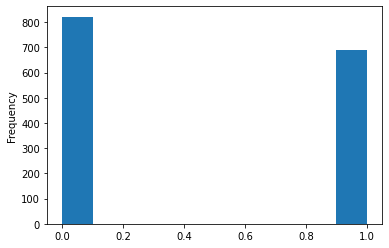

In [ ]:
df_5_c.Class.plot.hist()

In [ ]:
dataset_5_c = RegressionDataset(smiles_tokenizer, './bace_classification.csv', 512)

init dataset


0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-348097d7f35bdd26/0.0.0/ede98314803c971fef04bcee45d660c62f3332e8a74491e0b876106f3d99bd9b. Subsequent calls will reuse this data.
Loaded Dataset
Number of lines: 1513
Block size: 512


In [ ]:
train_dataset_5_c, eval_dataset_5_c = random_split(dataset_5_c, [1210, 303])

In [ ]:
class RobertaClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features[:, 0, :]  # take <s> token (equiv. to [CLS])
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


@dataclass
class SequenceClassifierOutput(ModelOutput):

    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None


class RobertaForSequenceClassification(RobertaPreTrainedModel):
    _keys_to_ignore_on_load_missing = ["position_ids"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.roberta = RobertaModel(config, add_pooling_layer=False)
        self.classifier = RobertaClassificationHead(config)

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        """
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for computing the sequence classification/regression loss. Indices should be in :obj:`[0, ...,
            config.num_labels - 1]`. If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = (
            return_dict if return_dict is not None else self.config.use_return_dict
        )

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = outputs[0]
        logits = self.classifier(sequence_output)

        if labels is None:
            return logits

        loss = None
        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(
                    logits.view(-1, self.num_labels), labels.long().view(-1)
                )

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )



In [ ]:
config_c = RobertaConfig(
        vocab_size = 600,
        max_position_embeddings = 515,
        num_attention_heads = 6,
        num_hidden_layers = 6,
        type_vocab_size = 1,
        num_labels = 2,
        is_gpu = True
    )
model = RobertaForSequenceClassification(config = config_c)

In [ ]:
!mkdir bace_classification_model
!mkdir bace_classification_model_overwrite

mkdir: cannot create directory ‘bace_classification_model’: File exists
mkdir: cannot create directory ‘bace_classification_model_overwrite’: File exists


In [ ]:
training_args = TrainingArguments(
        output_dir = "./bace_classification_model",
        overwrite_output_dir = './bace_classification_model_overwrite',
        num_train_epochs = 25,
        per_device_train_batch_size = 32,
        save_steps = 100,
        save_total_limit = 10,
        fp16 = True
    )


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=multitask_data_collator,
    train_dataset=train_dataset_5_c, 
    eval_dataset = eval_dataset_5_c,
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend


In [ ]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1210
  Num Epochs = 25
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 950
  Number of trainable parameters = 43977986
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss
500,0.499700


Saving model checkpoint to ./bace_classification_model/checkpoint-100
Configuration saved in ./bace_classification_model/checkpoint-100/config.json
Model weights saved in ./bace_classification_model/checkpoint-100/pytorch_model.bin
Deleting older checkpoint [bace_classification_model/checkpoint-600] due to args.save_total_limit
Saving model checkpoint to ./bace_classification_model/checkpoint-200
Configuration saved in ./bace_classification_model/checkpoint-200/config.json
Model weights saved in ./bace_classification_model/checkpoint-200/pytorch_model.bin
Deleting older checkpoint [bace_classification_model/checkpoint-700] due to args.save_total_limit
Saving model checkpoint to ./bace_classification_model/checkpoint-300
Configuration saved in ./bace_classification_model/checkpoint-300/config.json
Model weights saved in ./bace_classification_model/checkpoint-300/pytorch_model.bin
Deleting older checkpoint [bace_classification_model/checkpoint-800] due to args.save_total_limit
Saving mod

TrainOutput(global_step=950, training_loss=0.3912828706440173, metrics={'train_runtime': 104.8108, 'train_samples_per_second': 288.615, 'train_steps_per_second': 9.064, 'total_flos': 4007138809344000.0, 'train_loss': 0.3912828706440173, 'epoch': 25.0})

In [ ]:
model_5 = trainer.model

In [ ]:
model_5

In [ ]:
valid_dl = torch.utils.data.DataLoader(eval_dataset_5_c, batch_size = 32)

In [ ]:
batch = next(iter(valid_dl))

In [ ]:
x, y = batch['input_ids'], batch['label']

In [ ]:
x.shape, y.shape

(torch.Size([32, 512]), torch.Size([32]))

In [ ]:
x = x.cuda()
y = y.cuda()


In [ ]:
yhat = F.softmax(model_5(x))

<ipython-input-128-3f666fb89fff>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yhat = F.softmax(model_5(x))


In [ ]:
from sklearn.metrics import roc_auc_score


def roc_auc(yhat, y):
# Convert logits and labels to numpy arrays
  logits_np = yhat.detach().cpu().numpy()
  labels_np = y.detach().cpu().numpy()

  # Compute ROC AUC
  roc_auc = roc_auc_score(labels_np, logits_np[:, 1])

  return roc_auc

In [ ]:
!ls gdrive/MyDrive/chem_datasets

bace_classification_anton.csv  data_PAMPA7_4.csv
bace.csv		       data_PAMPA7_4_input.csv
bace_regression_anton.csv      data_PgpInh_DOD_SALI_lt20_2191.csv
bbbp.csv		       dataset-delaney.csv
clearance.csv		       lipo.csv
clintox_anton.csv	       smiles_cas_N6512_icmSmiles.csv
data_HLM_DOD.csv


In [ ]:
bace = pd.read_csv('gdrive/MyDrive/chem_datasets/bace_regression_anton.csv')

In [ ]:
bace.head()

,Unnamed: 0,pIC50,w,ids
0,0,1.065249,1.0,Fc1ccc(cc1C#CCCCF)[C@]1(N=C(N)N(C)C1=O)c1ccc(O...
1,1,1.173876,1.0,FCC#Cc1cc(ccc1)[C@]1(N=C(N)N(C)C1=O)c1ccc(OC(F...
2,2,1.173876,1.0,FCCC#Cc1cc(ccc1)[C@]1(N=C(N)N(C)C1=O)c1ccc(OC(...
3,3,1.173876,1.0,FC(F)Oc1ccc(cc1)[C@@]1(N=C(N)N(C)C1=O)c1cc(ccc...
4,4,1.173876,1.0,FC(F)Oc1ccc(cc1)[C@@]1(N=C(N)N(C)C1=O)c1cc(ccc...


In [ ]:
bace_c = pd.read_csv('gdrive/MyDrive/chem_datasets/bace_classification_anton.csv')
bace_c.head()

,Unnamed: 0,Class,w,ids
0,0,1.0,2.349515,Fc1ccc(cc1C#CCCCF)[C@]1(N=C(N)N(C)C1=O)c1ccc(O...
1,1,1.0,2.349515,FCC#Cc1cc(ccc1)[C@]1(N=C(N)N(C)C1=O)c1ccc(OC(F...
2,2,1.0,2.349515,FCCC#Cc1cc(ccc1)[C@]1(N=C(N)N(C)C1=O)c1ccc(OC(...
3,3,1.0,2.349515,FC(F)Oc1ccc(cc1)[C@@]1(N=C(N)N(C)C1=O)c1cc(ccc...
4,4,1.0,2.349515,FC(F)Oc1ccc(cc1)[C@@]1(N=C(N)N(C)C1=O)c1cc(ccc...


## **BACE Regression- Anton ** 


In [ ]:
smiles_tokenizer = RobertaTokenizerFast.from_pretrained("seyonec/SMILES_tokenized_PubChem_shard00_160k", max_len = 512)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
bace.head()

,Unnamed: 0,pIC50,w,ids
0,0,1.065249,1.0,Fc1ccc(cc1C#CCCCF)[C@]1(N=C(N)N(C)C1=O)c1ccc(O...
1,1,1.173876,1.0,FCC#Cc1cc(ccc1)[C@]1(N=C(N)N(C)C1=O)c1ccc(OC(F...
2,2,1.173876,1.0,FCCC#Cc1cc(ccc1)[C@]1(N=C(N)N(C)C1=O)c1ccc(OC(...
3,3,1.173876,1.0,FC(F)Oc1ccc(cc1)[C@@]1(N=C(N)N(C)C1=O)c1cc(ccc...
4,4,1.173876,1.0,FC(F)Oc1ccc(cc1)[C@@]1(N=C(N)N(C)C1=O)c1cc(ccc...


In [ ]:
bace = bace.drop(['Unnamed: 0', 'w'], axis = 1)

In [ ]:
bace = bace.iloc[:, ::-1]

In [ ]:
!ls gdirve

gdrive	sample_data  vocab.txt


In [ ]:
bace.to_csv('gdrive/MyDrive/chem_datasets/bace_reg_cleaned.csv')

In [ ]:
bace_ds = RegressionDataset(smiles_tokenizer, 'gdrive/MyDrive/chem_datasets/bace_reg_cleaned.csv', 512)

init dataset


Downloading:   0%|          | 0.00/2.75k [00:00<?, ?B/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-1a7c2cc29c92d435/0.0.0/ede98314803c971fef04bcee45d660c62f3332e8a74491e0b876106f3d99bd9b. Subsequent calls will reuse this data.
Loaded Dataset
Number of lines: 1513
Block size: 512


In [ ]:
bace_ds[0]

In [ ]:
def get_trainer(dataset, num_labels = 1, model_class = RobertaForRegression, output_dir = './reg_model'):
  config = RobertaConfig(
        vocab_size = 600,
        max_position_embeddings = 515,
        num_attention_heads = 6,
        num_hidden_layers = 6,
        type_vocab_size = 1,
        num_labels = num_labels,
        is_gpu = True
    )

  model = model_class(config=config)
  model = model.cuda()

  training_args = TrainingArguments(
        evaluation_strategy="steps",
        eval_steps = 10,
        logging_steps = 10,
        load_best_model_at_end = True,
        output_dir = output_dir,
        overwrite_output_dir = output_dir,
        num_train_epochs = 25,
        per_device_train_batch_size = 32,
        save_steps = 100,
        save_total_limit = 5,
        fp16 = True
    )
  
  train_dataset, valid_dataset = random_split(dataset, lengths = [int(0.8*len(dataset)), len(dataset) - int(0.8*len(dataset))])

  trainer = Trainer(
        model = model,
        args = training_args,
        data_collator = multitask_data_collator,
        train_dataset = train_dataset,
        eval_dataset = valid_dataset,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    )

  return trainer

In [ ]:
!mkdir ./bace_reg_model_03_02_2023

In [ ]:
trainer = get_trainer(bace_ds, output_dir = './bace_reg_model_03_02_2023')

Using cuda_amp half precision backend


In [ ]:
def manual_evaluate_model(trainer, metric_func):
  model = trainer.model
  valid_ds = trainer.eval_dataset
  valid_loader = DataLoader(valid_ds, batch_size = 32, shuffle = True)
  metrics = []
  for dd in valid_loader:
    x, y = dd['input_ids'].cuda(), dd['label'].cuda()
    yhat = model(x)
    metrics.append(metric_func(yhat, y))

In [ ]:
trainer.train()

In [ ]:
model = trainer.model

In [ ]:
valid_ds = trainer.eval_dataset

In [ ]:
valid_loader = DataLoader(valid_ds, batch_size = 100, shuffle = True)

In [ ]:
dd = next(iter(valid_loader))

In [ ]:
x, y = dd['input_ids'].cuda(), dd['label'].cuda()

In [ ]:
yhat = model(x)

In [ ]:
loss_func = nn.MSELoss()

In [ ]:
yhat.shape

torch.Size([100, 1])

In [ ]:
loss_func(yhat.squeeze(), y)

tensor(1.6373, device='cuda:0', grad_fn=<MseLossBackward0>)

In [ ]:
x, y, yhat.squeeze()

(tensor([[12, 27, 15,  ...,  0,  0,  0],
         [12, 27, 15,  ...,  0,  0,  0],
         [12, 34, 17,  ...,  0,  0,  0],
         ...,
         [12, 19, 22,  ...,  0,  0,  0],
         [12, 27, 15,  ...,  0,  0,  0],
         [12, 16, 15,  ...,  0,  0,  0]], device='cuda:0'),
 tensor([ 0.7884,  0.6543,  0.3611,  0.8192,  0.8192, -1.0595, -0.2243,  0.4792,
          0.0451,  0.5277, -1.4634, -1.2120,  1.1739,  0.0652,  0.6648,  0.5411,
          0.5234,  0.9501,  0.4337,  0.3716, -0.4438, -1.5038,  1.2459, -1.5758,
          0.7884,  1.3230,  1.5626,  1.2668, -0.1370, -0.0522,  0.9501, -0.4605,
         -1.7796,  1.1431, -0.4646,  0.9667,  1.3335, -0.1826,  0.0652, -1.0870,
          0.9050,  0.5954, -0.3663,  1.1431, -1.9031,  0.8192,  0.6294,  1.3442,
         -1.0562,  0.9137,  0.7263,  0.9501,  1.0892,  1.7459,  1.1739,  1.3335,
          0.8415, -0.1257,  1.0892, -1.0562,  1.0892,  0.7263,  0.5025,  0.6543,
         -1.1977,  0.0868, -0.8967, -1.5149, -0.0544,  0.3219,  0.0652, -

# **Bace Classification - Anton**

In [ ]:
bace_c = pd.read_csv('gdrive/MyDrive/chem_datasets/bace_classification_anton.csv')
bace_c = bace_c.drop(['Unnamed: 0', 'w'], axis = 1)
bace_c.head()

,Class,ids
0,1.0,Fc1ccc(cc1C#CCCCF)[C@]1(N=C(N)N(C)C1=O)c1ccc(O...
1,1.0,FCC#Cc1cc(ccc1)[C@]1(N=C(N)N(C)C1=O)c1ccc(OC(F...
2,1.0,FCCC#Cc1cc(ccc1)[C@]1(N=C(N)N(C)C1=O)c1ccc(OC(...
3,1.0,FC(F)Oc1ccc(cc1)[C@@]1(N=C(N)N(C)C1=O)c1cc(ccc...
4,1.0,FC(F)Oc1ccc(cc1)[C@@]1(N=C(N)N(C)C1=O)c1cc(ccc...


In [ ]:
bace_c = bace_c.iloc[:, ::-1]
bace_c.to_csv('gdrive/MyDrive/chem_datasets/bace_classification_anton_cleaned.csv')

In [ ]:
bace_c.head()

,ids,Class
0,Fc1ccc(cc1C#CCCCF)[C@]1(N=C(N)N(C)C1=O)c1ccc(O...,1.0
1,FCC#Cc1cc(ccc1)[C@]1(N=C(N)N(C)C1=O)c1ccc(OC(F...,1.0
2,FCCC#Cc1cc(ccc1)[C@]1(N=C(N)N(C)C1=O)c1ccc(OC(...,1.0
3,FC(F)Oc1ccc(cc1)[C@@]1(N=C(N)N(C)C1=O)c1cc(ccc...,1.0
4,FC(F)Oc1ccc(cc1)[C@@]1(N=C(N)N(C)C1=O)c1cc(ccc...,1.0


<AxesSubplot:ylabel='Frequency'>

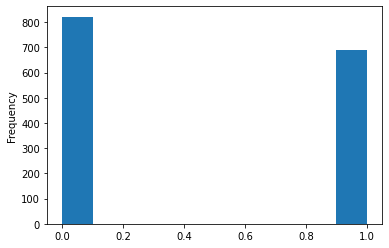

In [ ]:
bace_c.Class.plot.hist()

In [ ]:
bace_c = bace_c.sample(frac = 1).reset_index(drop = True)

In [ ]:
bace_c_ds = RegressionDataset(smiles_tokenizer, 'gdrive/MyDrive/chem_datasets/bace_classification_anton_cleaned.csv', 512)

init dataset


Loaded Dataset
Number of lines: 1513
Block size: 512


In [ ]:
bace_c_ds[10]

In [ ]:
!mkdir bace_classification_03_02_2023

mkdir: cannot create directory ‘bace_classification_03_02_2023’: File exists


In [ ]:
# num_labels = 1, model_class = RobertaForRegression, output_dir = './reg_model'
trainer = get_trainer(bace_c_ds, num_labels = 2, model_class = RobertaForSequenceClassification, output_dir = './bace_classification_03_02_2023')

Using cuda_amp half precision backend


In [ ]:
trainer.model

In [ ]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1210
  Num Epochs = 25
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 950
  Number of trainable parameters = 43977986
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pranayreddy8997. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
10,0.918400,0.739011
20,0.710600,0.679618
30,0.695300,0.683581
40,0.707000,0.706641
50,0.691300,0.695968
60,0.715900,0.688435
70,0.709200,0.668113
80,0.696200,0.668609
90,0.686100,0.696352
100,0.658500,0.801457


***** Running Evaluation *****
  Num examples = 303
  Batch size = 8
***** Running Evaluation *****
  Num examples = 303
  Batch size = 8
***** Running Evaluation *****
  Num examples = 303
  Batch size = 8
***** Running Evaluation *****
  Num examples = 303
  Batch size = 8
***** Running Evaluation *****
  Num examples = 303
  Batch size = 8
***** Running Evaluation *****
  Num examples = 303
  Batch size = 8
***** Running Evaluation *****
  Num examples = 303
  Batch size = 8
***** Running Evaluation *****
  Num examples = 303
  Batch size = 8
***** Running Evaluation *****
  Num examples = 303
  Batch size = 8
***** Running Evaluation *****
  Num examples = 303
  Batch size = 8
Saving model checkpoint to ./bace_classification_03_02_2023/checkpoint-100
Configuration saved in ./bace_classification_03_02_2023/checkpoint-100/config.json
Model weights saved in ./bace_classification_03_02_2023/checkpoint-100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 303
  Batch siz

TrainOutput(global_step=310, training_loss=0.6292014275827715, metrics={'train_runtime': 60.8326, 'train_samples_per_second': 497.266, 'train_steps_per_second': 15.617, 'total_flos': 1307718159532032.0, 'train_loss': 0.6292014275827715, 'epoch': 8.16})

In [ ]:
trainer.__dict__.keys()

dict_keys(['args', 'hp_name', 'deepspeed', 'is_in_train', '_memory_tracker', 'model_init', 'is_model_parallel', 'sharded_ddp', 'fsdp', 'place_model_on_device', 'data_collator', 'train_dataset', 'eval_dataset', 'tokenizer', 'model_wrapped', 'model', 'compute_metrics', 'preprocess_logits_for_metrics', 'optimizer', 'lr_scheduler', 'callback_handler', '_loggers_initialized', '_signature_columns', 'use_apex', 'use_cuda_amp', 'use_cpu_amp', 'do_grad_scaling', 'amp_dtype', 'scaler', 'label_smoother', 'state', 'control', 'current_flos', 'hp_search_backend', 'use_tune_checkpoints', 'label_names', 'can_return_loss', '_train_batch_size', '_trial', '_total_loss_scalar', '_globalstep_last_logged'])

In [ ]:
trainer.is_model_parallel

False

In [ ]:
roc_auc

<function __main__.roc_auc(yhat, y)>

In [ ]:
trainer_c = trainer

In [ ]:
def manual_evaluate_model_cpu(trainer, metric_func):
  model = trainer.model
  model = model.cpu()
  valid_ds = trainer.eval_dataset
  valid_loader = DataLoader(valid_ds, batch_size = len(valid_ds) - 1, shuffle = True)
  dd = next(iter(valid_loader))
  x, y = dd['input_ids'].cpu(), dd['label'].cpu()
  yhat = model(x)
  return metric_func(yhat, y)

In [ ]:
from copy import deepcopy

In [ ]:
model = trainer_c.model

In [ ]:
model.device

device(type='cuda', index=0)

In [ ]:
def roc_auc(yhat, y):
# Convert logits and labels to numpy arrays
  logits_np = yhat.detach().cpu().numpy()
  labels_np = y.detach().cpu().numpy()

  # Compute ROC AUC
  roc_auc = roc_auc_score(labels_np, logits_np[:, 1])

  return roc_auc

In [ ]:
model = trainer_c.model

valid_ds = trainer.eval_dataset
valid_loader = DataLoader(valid_ds, batch_size = 64, shuffle = True)
dd = next(iter(valid_loader))
x, y = dd['input_ids'].to(model.device), dd['label'].to(model.device)
# yhat = model(x)

In [ ]:
yhat = model(x)

In [ ]:
yhat.shape, y.shape

(torch.Size([64, 2]), torch.Size([64]))

In [ ]:
roc_auc(yhat, y)

0.7407407407407407

In [ ]:
yhat.shape, y.shape

(torch.Size([302, 1]), torch.Size([302]))

In [ ]:
trainer_c = None
model = None

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

3665

In [ ]:
!ls gdrive/MyDrive/chem_datasets

bace_classification_anton_cleaned.csv  data_HLM_DOD.csv
bace_classification_anton.csv	       data_PAMPA7_4.csv
bace.csv			       data_PAMPA7_4_input.csv
bace_reg_cleaned.csv		       data_PgpInh_DOD_SALI_lt20_2191.csv
bace_regression_anton.csv	       dataset-delaney.csv
bbbp.csv			       lipo.csv
clearance.csv			       smiles_cas_N6512_icmSmiles.csv
clintox_anton.csv


# BBBP dataset

In [ ]:
bbbp = pd.read_csv('gdrive/MyDrive/chem_datasets/bbbp.csv')

In [ ]:
bbbp.head()

,Unnamed: 0,p_np,w,ids
0,0,1.0,1.216257,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
1,1,1.0,1.216257,C[C@H](N)Cc1ccccc1
2,2,1.0,1.216257,C[S](=O)(=O)c1ccc(cc1)[C@@H](O)[C@@H](CO)NC(=O...
3,3,1.0,1.216257,CC(N)COc1c(C)cccc1C
4,4,1.0,1.216257,c1(ccccc1)CC


In [ ]:
bbbp = bbbp.drop(['Unnamed: 0', 'w'], axis = 1)

In [ ]:
bbbp = bbbp.iloc[:, ::-1]
bbbp = bbbp.sample(frac = 1).reset_index(drop = True)

In [ ]:
bbbp.head()

,ids,p_np
0,C1=C(C=CC=C1)C(C2=CC=CC=C2)(C3NCCCC3)O,1.0
1,C1=CC(=CC2=C1N(C(=O)N2)CCCN4CCC(C(C3=CC=C(F)C=...,1.0
2,CN(C)C3CCc2[nH]c1c(F)cc(F)cc1c2C3,1.0
3,CO[C@@]12[C@H](COC(N)=O)C3=C(N1C[C@@H]4N[C@H]2...,0.0
4,CO[C@]1(NC(=O)CSCC#N)[C@H]2SCC(=C(N2C1=O)C(O)=...,0.0


In [ ]:
bbbp.to_csv('./gdrive/MyDrive/chem_datasets/bbbp_cleaned.csv')

<AxesSubplot:ylabel='Frequency'>

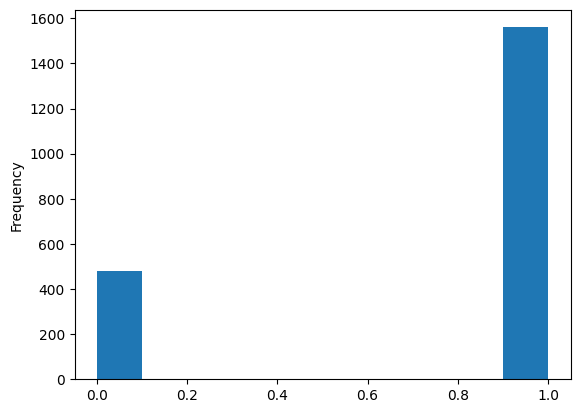

In [ ]:
bbbp['p_np'].plot.hist()

In [ ]:
bbbp_ds = RegressionDataset(smiles_tokenizer, './gdrive/MyDrive/chem_datasets/bbbp_cleaned.csv', 512)

init dataset


0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-aef599dd01faa77e/0.0.0/ede98314803c971fef04bcee45d660c62f3332e8a74491e0b876106f3d99bd9b. Subsequent calls will reuse this data.
Loaded Dataset
Number of lines: 2039
Block size: 512


In [ ]:
bbbp_ds[4]

In [ ]:
!mkdir ./bbbp_model_03_02_2023

In [ ]:
# trainer = get_trainer(bace_c_ds, num_labels = 2, model_class = RobertaForSequenceClassification, output_dir = './bace_classification_03_02_2023')

In [ ]:
trainer_bbbp = get_trainer(bbbp_ds, num_labels = 2, model_class = RobertaForSequenceClassification, output_dir = './bbbp_model_03_02_2023/')

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend


In [ ]:
trainer_bbbp.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1631
  Num Epochs = 25
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1275
  Number of trainable parameters = 43977986
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss
10,0.617000,0.589155
20,0.609900,0.530163
30,0.497000,0.486217
40,0.445000,0.379299
50,0.346300,0.378161
60,0.418700,0.347551
70,0.370600,0.325535
80,0.365000,0.300480
90,0.384900,0.286631
100,0.336400,0.347756


***** Running Evaluation *****
  Num examples = 408
  Batch size = 8
***** Running Evaluation *****
  Num examples = 408
  Batch size = 8
***** Running Evaluation *****
  Num examples = 408
  Batch size = 8
***** Running Evaluation *****
  Num examples = 408
  Batch size = 8
***** Running Evaluation *****
  Num examples = 408
  Batch size = 8
***** Running Evaluation *****
  Num examples = 408
  Batch size = 8
***** Running Evaluation *****
  Num examples = 408
  Batch size = 8
***** Running Evaluation *****
  Num examples = 408
  Batch size = 8
***** Running Evaluation *****
  Num examples = 408
  Batch size = 8
***** Running Evaluation *****
  Num examples = 408
  Batch size = 8
Saving model checkpoint to ./bbbp_model_03_02_2023/checkpoint-100
Configuration saved in ./bbbp_model_03_02_2023/checkpoint-100/config.json
Model weights saved in ./bbbp_model_03_02_2023/checkpoint-100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 408
  Batch size = 8
***** Running Evaluat

TrainOutput(global_step=480, training_loss=0.30343177790443104, metrics={'train_runtime': 88.2893, 'train_samples_per_second': 461.834, 'train_steps_per_second': 14.441, 'total_flos': 2033507036768256.0, 'train_loss': 0.30343177790443104, 'epoch': 9.41})

In [ ]:
model = trainer_bbbp.model

valid_ds = trainer_bbbp.eval_dataset
valid_loader = DataLoader(valid_ds, batch_size = 32, shuffle = True)
# dd = next(iter(valid_loader))
# x, y = dd['input_ids'].to(model.device), dd['label'].to(model.device)
# yhat = model(x)

In [ ]:
aucs = []
for dd in valid_loader:
  x, y = dd['input_ids'].to(model.device), dd['label'].to(model.device)
  yhat = model(x)
  aucs.append(roc_auc(yhat, y))

In [ ]:
np.mean(aucs)

0.8538484508802233

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
def calculate_metrics(yhat, y):
  logits_np = yhat.detach().cpu().numpy()
  labels_np = y.long().detach().cpu().numpy()

  # Compute accuracy, precision, and recall
  preds = logits_np.argmax(axis=1)
  accuracy = accuracy_score(labels_np, preds)
  precision = precision_score(labels_np, preds)
  recall = recall_score(labels_np, preds)
  return accuracy, precision, recall

accs = []
precision = []
recall = []
aucs = []

for dd in valid_loader:
  x, y = dd['input_ids'].to(model.device), dd['label'].to(model.device)
  yhat = model(x)
  aucs.append(roc_auc(yhat, y))
  acc, prec, rec = calculate_metrics(yhat, y)
  accs.append(acc)
  precision.append(prec)
  recall.append(rec)

In [ ]:
accs = []
precision = []
recall = []

for dd in valid_loader:
  x, y = dd['input_ids'].to(model.device), dd['label'].to(model.device)
  yhat = model(x)
  acc, prec, rec = calculate_metrics(yhat, y)
  accs.append(acc)
  precision.append(prec)
  recall.append(rec)

In [ ]:
#recall = true positives / (true positives + false negatives)

In [ ]:
np.mean(accs), np.mean(precision), np.mean(recall)

(0.686698717948718, 0.9538919413919414, 0.6146645084051381)

In [ ]:
#precision = precision = true positives / (true positives + false positives)

# CLEARENCE

In [ ]:
!wget https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/clearance.csv

--2023-03-02 21:14:34--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/clearance.csv
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 52.219.120.177
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|52.219.120.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60307 (59K) [text/csv]
Saving to: ‘clearance.csv’

clearance.csv       100%[===================>]  58.89K  --.-KB/s    in 0.05s   

2023-03-02 21:14:35 (1.16 MB/s) - ‘clearance.csv’ saved [60307/60307]



In [ ]:
df = pd.read_csv('clearance.csv')

In [ ]:
df.head()

,id,target,smiles
0,CHEMBL2147569,52.48,C[C@]12Cc3cnn(c3C=C1CC[C@@]2(O)CCc4ccc(F)cc4C(...
1,CHEMBL2348651,150.00,CNc1nc(C)c(s1)c2nc(Nc3cccc(c3)N4CCCN(CC4)C(=O)...
2,CHEMBL2023489,23.44,COc1ccc2c(Oc3ccc(CC(=O)Nc4cn(C)nc4C)c(OC)c3)cc...
3,CHEMBL1486510,150.00,CCOC(=O)c1c(C)n(Cc2occc2)c3ccc(O)cc13
4,CHEMBL2070942,150.00,CC(C)(C)c1csc(n1)N2CCN(CC2)C(=O)[C@@H]3CCCC[C@...


In [ ]:
clearance = df

In [ ]:
clearance.drop(['id'], axis = 1, inplace = True)

In [ ]:
clearance = clearance.iloc[:, ::-1]

In [ ]:
clearance.to_csv('./gdrive/MyDrive/chem_datasets/clearance_cleaned.csv')

In [ ]:
clearance.head()

,smiles,target
0,C[C@]12Cc3cnn(c3C=C1CC[C@@]2(O)CCc4ccc(F)cc4C(...,52.48
1,CNc1nc(C)c(s1)c2nc(Nc3cccc(c3)N4CCCN(CC4)C(=O)...,150.00
2,COc1ccc2c(Oc3ccc(CC(=O)Nc4cn(C)nc4C)c(OC)c3)cc...,23.44
3,CCOC(=O)c1c(C)n(Cc2occc2)c3ccc(O)cc13,150.00
4,CC(C)(C)c1csc(n1)N2CCN(CC2)C(=O)[C@@H]3CCCC[C@...,150.00


<AxesSubplot:ylabel='Frequency'>

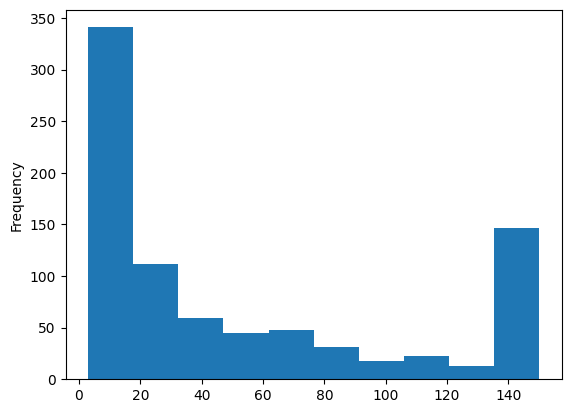

In [ ]:
clearance.target.plot.hist()

<AxesSubplot:>

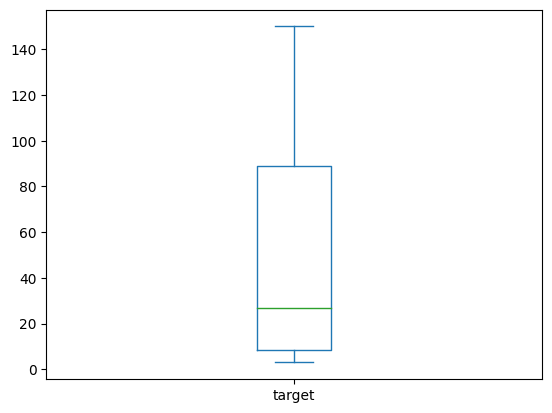

In [ ]:
clearance.target.plot.box()

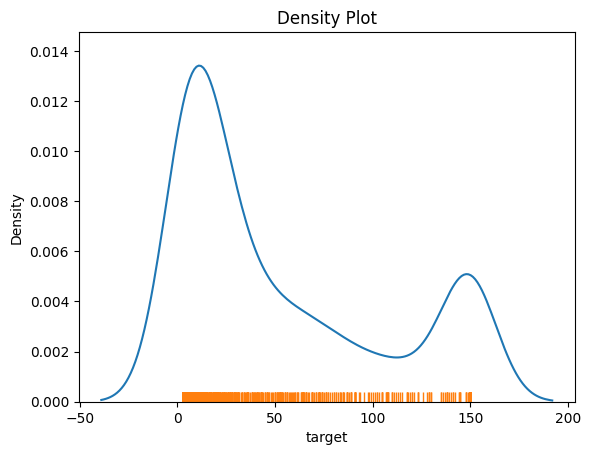

In [ ]:
sns.kdeplot(clearance['target'])
sns.rugplot(clearance['target'])
sns.set_style('whitegrid')
plt.xlabel('target')
plt.ylabel('Density')
plt.title('Density Plot')
plt.show()

In [ ]:
clear_ds = RegressionDataset(smiles_tokenizer, './gdrive/MyDrive/chem_datasets/clearance_cleaned.csv', 512)

init dataset


Loaded Dataset
Number of lines: 837
Block size: 512


In [ ]:
clear_ds[10]

In [ ]:
clear_trainer = get_trainer(clear_ds)

Using cuda_amp half precision backend


In [ ]:
clear_trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 669
  Num Epochs = 25
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 525
  Number of trainable parameters = 43977217
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pranayreddy8997. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
10,5477.777000,5797.106934
20,5148.147700,5403.390625
30,4421.502700,5218.814941
40,4692.507400,5020.760254
50,4335.855500,4832.688477
60,4388.566000,4647.131836
70,3520.222300,4467.561035
80,4259.519900,4294.735352
90,4139.648000,4129.942383
100,3680.622700,3977.686768


***** Running Evaluation *****
  Num examples = 168
  Batch size = 8
***** Running Evaluation *****
  Num examples = 168
  Batch size = 8
***** Running Evaluation *****
  Num examples = 168
  Batch size = 8
***** Running Evaluation *****
  Num examples = 168
  Batch size = 8
***** Running Evaluation *****
  Num examples = 168
  Batch size = 8
***** Running Evaluation *****
  Num examples = 168
  Batch size = 8
***** Running Evaluation *****
  Num examples = 168
  Batch size = 8
***** Running Evaluation *****
  Num examples = 168
  Batch size = 8
***** Running Evaluation *****
  Num examples = 168
  Batch size = 8
***** Running Evaluation *****
  Num examples = 168
  Batch size = 8
Saving model checkpoint to ./reg_model/checkpoint-100
Configuration saved in ./reg_model/checkpoint-100/config.json
Model weights saved in ./reg_model/checkpoint-100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 168
  Batch size = 8
***** Running Evaluation *****
  Num examples = 168
  Bat

TrainOutput(global_step=450, training_loss=3183.4587977430556, metrics={'train_runtime': 74.1395, 'train_samples_per_second': 225.588, 'train_steps_per_second': 7.081, 'total_flos': 1899151225261056.0, 'train_loss': 3183.4587977430556, 'epoch': 21.43})

In [ ]:
lf = nn.MSELoss()

In [ ]:
# losses = manual_evaluate_model(clear_trainer, nn.MSELoss())

In [ ]:
clear_model = clear_trainer.model
valid_dl = DataLoader(clear_trainer.eval_dataset, batch_size = 8, shuffle = True)

In [ ]:
clear_model.eval()
losses = []
for dd in valid_dl:
  x, y = dd['input_ids'].to(clear_model.device), dd['label'].to(clear_model.device)
  yhat = clear_model(x)
  losses.append(lf(yhat.squeeze(), y).item())

In [ ]:
losses = [i.item() for i in losses]
np.sqrt(np.mean(losses))

55.81737385109418

In [ ]:
model = clear_trainer.model
clear_trainer = None
model = None


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

260

# clintox

In [ ]:
df = pd.read_csv('./gdrive/MyDrive/chem_datasets/clintox_anton.csv')

In [ ]:
df.head()

,Unnamed: 0,FDA_APPROVED,CT_TOX,w1,w2,ids
0,0,0.0,1.0,14.962025,12.442105,B([C@H](CC(C)C)NC(=O)CNC(=O)C1=C(C=CC(=C1)Cl)C...
1,1,1.0,0.0,1.071623,1.087397,C(CO)N(c1c(c(c(c(c1I)C(=O)NCC(CO)O)I)C(=O)NCC(...
2,2,1.0,0.0,1.071623,1.087397,c1c(c(cc(c1Cl)Cl)Cl)OCC#CI
3,3,1.0,0.0,1.071623,1.087397,c1c(cc(c(c1NC(=O)C(=O)[O-])Cl)NC(=O)C(=O)[O-])C#N
4,4,1.0,0.0,1.071623,1.087397,c1c(cc(c(c1S(=O)(=O)N)Cl)Cl)S(=O)(=O)N


In [ ]:
df = df[['CT_TOX', 'ids']]

In [ ]:
df.head()

,CT_TOX,ids
0,1.0,B([C@H](CC(C)C)NC(=O)CNC(=O)C1=C(C=CC(=C1)Cl)C...
1,0.0,C(CO)N(c1c(c(c(c(c1I)C(=O)NCC(CO)O)I)C(=O)NCC(...
2,0.0,c1c(c(cc(c1Cl)Cl)Cl)OCC#CI
3,0.0,c1c(cc(c(c1NC(=O)C(=O)[O-])Cl)NC(=O)C(=O)[O-])C#N
4,0.0,c1c(cc(c(c1S(=O)(=O)N)Cl)Cl)S(=O)(=O)N


<AxesSubplot:ylabel='Frequency'>

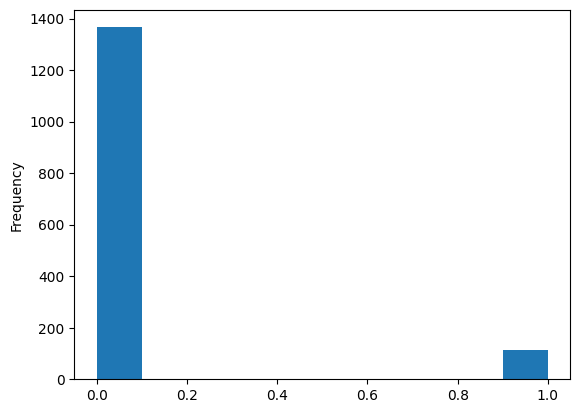

In [ ]:
df['CT_TOX'].plot.hist()

In [ ]:
df = df.iloc[:, ::-1]

In [ ]:
df.head()

,ids,CT_TOX
0,B([C@H](CC(C)C)NC(=O)CNC(=O)C1=C(C=CC(=C1)Cl)C...,1.0
1,C(CO)N(c1c(c(c(c(c1I)C(=O)NCC(CO)O)I)C(=O)NCC(...,0.0
2,c1c(c(cc(c1Cl)Cl)Cl)OCC#CI,0.0
3,c1c(cc(c(c1NC(=O)C(=O)[O-])Cl)NC(=O)C(=O)[O-])C#N,0.0
4,c1c(cc(c(c1S(=O)(=O)N)Cl)Cl)S(=O)(=O)N,0.0


In [ ]:
df = df.sample(frac = 1).reset_index(drop = True)

In [ ]:
df.head()

,ids,CT_TOX
0,c1nc(nc(=O)n1[C@H]2[C@@H]([C@@H]([C@H](O2)CO)O...,0.0
1,C[C@@H]1C[C@H]2[C@@H]3C[C@@H](C4=CC(=O)C=C[C@@...,0.0
2,C[NH+](C)CCC(c1ccc(cc1)Br)c2ccccn2,0.0
3,CC(C)O,0.0
4,CN1C(=C(c2ccccc2S1(=O)=O)O)C(=O)Nc3ccccn3,0.0


In [ ]:
df.to_csv('./gdrive/MyDrive/chem_datasets/clintox_cleaned.csv')

In [ ]:
clintox_ds = RegressionDataset(smiles_tokenizer, './gdrive/MyDrive/chem_datasets/clintox_cleaned.csv', 512)

init dataset


Downloading:   0%|          | 0.00/2.75k [00:00<?, ?B/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-33d0d773c16bfb77/0.0.0/ede98314803c971fef04bcee45d660c62f3332e8a74491e0b876106f3d99bd9b. Subsequent calls will reuse this data.
Loaded Dataset
Number of lines: 1478
Block size: 512


In [ ]:
clintox_ds[0]

In [ ]:
clintox_trainer = get_trainer(clintox_ds, num_labels = 2, model_class = RobertaForSequenceClassification)

Using cuda_amp half precision backend


In [ ]:
clintox_trainer.train()

In [ ]:
valid_dl = DataLoader(clintox_trainer.eval_dataset, batch_size = 8, shuffle = True)

In [ ]:
roc_auc

<function __main__.roc_auc(yhat, y)>

In [ ]:
model = clintox_trainer.model

In [ ]:
model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
def calculate_metrics(yhat, y):
  logits_np = yhat.detach().cpu().numpy()
  labels_np = y.long().detach().cpu().numpy()

  # Compute accuracy, precision, and recall
  preds = logits_np.argmax(axis=1)
  accuracy = accuracy_score(labels_np, preds)
  precision = precision_score(labels_np, preds)
  recall = recall_score(labels_np, preds)
  return accuracy, precision, recall

accs = []
precision = []
recall = []
aucs = []

for dd in valid_dl:
  x, y = dd['input_ids'].to(model.device), dd['label'].to(model.device)
  yhat = F.softmax(model(x))
  # print(x.shape, y.shape)
  # print(x.shape, y.shape, yhat.shape)
  try:
    auc = roc_auc(yhat, y)
    aucs.append(auc)
  except:
    print('cool')
  acc, prec, rec = calculate_metrics(yhat, y)
  accs.append(acc)
  precision.append(prec)
  recall.append(rec)

<ipython-input-45-2be1d0550a50>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yhat = F.softmax(model(x))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-45-2be1d0550a50>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yhat = F.softmax(model(x))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_

cool
cool


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-45-2be1d0550a50>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yhat = F.softmax(model(x))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn

cool
cool


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-45-2be1d0550a50>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yhat = F.softmax(model(x))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-45-2be1d0550a50>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yhat = F.softmax(model(x))
/usr/local/lib/python3.8/dist-packages/sklearn/m

cool


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-45-2be1d0550a50>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yhat = F.softmax(model(x))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-45-2be1d0550a50>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yhat = F.softmax(model(x))
/usr/local/lib/python3.8/dist-packages/sklearn/m

cool
cool
cool
cool
cool


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-45-2be1d0550a50>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yhat = F.softmax(model(x))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

cool
cool
cool


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-45-2be1d0550a50>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yhat = F.softmax(model(x))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn

cool
cool
cool
cool
cool


<ipython-input-45-2be1d0550a50>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yhat = F.softmax(model(x))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-45-2be1d0550a50>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yhat = F.softmax(model(x))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_

In [ ]:
aucs

[1.0,
 1.0,
 0.5714285714285714,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.8571428571428572,
 1.0,
 1.0,
 0.7142857142857143,
 1.0,
 1.0,
 0.8571428571428572]

In [ ]:
np.mean(accs), np.mean(aucs), np.mean(precision), np.mean(recall)

(0.9121621621621622, 0.9473684210526315, 0.0, 0.0)

In [ ]:
yhat, y

(tensor([[0.9972, 0.0028],
         [0.9954, 0.0046],
         [0.9980, 0.0020],
         [0.9973, 0.0027],
         [0.9964, 0.0036],
         [0.9972, 0.0028],
         [0.9973, 0.0027],
         [0.9944, 0.0056]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0'))

In [ ]:
np.mean([0.5714285714285714, 0.8571428571428572, 0.7142857142857143, 0.8571428571428572])

0.75

In [ ]:
roc_auc(F.softmax(yhat), y)

<ipython-input-38-305e42f7be63>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  roc_auc(F.softmax(yhat), y)


1.0

In [ ]:
model = None
clintox_trainer = None

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

# LIPO

In [ ]:
!ls gdrive/MyDrive/chem_datasets

bace_classification_anton_cleaned.csv  clintox_anton.csv
bace_classification_anton.csv	       clintox_cleaned.csv
bace.csv			       data_HLM_DOD.csv
bace_reg_cleaned.csv		       data_PAMPA7_4.csv
bace_regression_anton.csv	       data_PAMPA7_4_input.csv
bbbp_cleaned.csv		       data_PgpInh_DOD_SALI_lt20_2191.csv
bbbp.csv			       dataset-delaney.csv
clearance_cleaned.csv		       lipo.csv
clearance.csv			       smiles_cas_N6512_icmSmiles.csv


In [ ]:
lipo = pd.read_csv('gdrive/MyDrive/chem_datasets/lipo.csv')

In [ ]:
lipo.head()

,Unnamed: 0,exp,w,ids
0,0,-1.703482,1.0,CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1
1,1,-2.892589,1.0,Cc1ccc(NC(=N)N)cc1C
2,2,-1.909924,1.0,CC(C)C(=O)NCCNCC(O)COc1ccc(O)cc1
3,3,0.749051,1.0,C[C@@](O)(C(=O)Nc1ccc(cc1Cl)S(=O)(=O)NCC=C)C(F...
4,4,-1.620905,1.0,CC(C)NCC(O)COc1ccccc1OCC=C


In [ ]:
lipo = lipo[['exp', 'ids']]

In [ ]:
lipo = lipo.iloc[:, ::-1]

In [ ]:
lipo.head()

,ids,exp
0,CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1,-1.703482
1,Cc1ccc(NC(=N)N)cc1C,-2.892589
2,CC(C)C(=O)NCCNCC(O)COc1ccc(O)cc1,-1.909924
3,C[C@@](O)(C(=O)Nc1ccc(cc1Cl)S(=O)(=O)NCC=C)C(F...,0.749051
4,CC(C)NCC(O)COc1ccccc1OCC=C,-1.620905


In [ ]:
lipo.to_csv('./gdrive/MyDrive/chem_datasets/lipo_cleaned.csv')

In [ ]:
lipo_ds = RegressionDataset(smiles_tokenizer, './gdrive/MyDrive/chem_datasets/lipo_cleaned.csv', 512)

init dataset


0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-7ed07fcb48e9def7/0.0.0/ede98314803c971fef04bcee45d660c62f3332e8a74491e0b876106f3d99bd9b. Subsequent calls will reuse this data.
Loaded Dataset
Number of lines: 4200
Block size: 512


In [ ]:
lipo_ds[2]

In [ ]:
lipo_trainer = get_trainer(lipo_ds)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend


In [ ]:
lipo_trainer.train()

In [ ]:
valid_dl = DataLoader(lipo_trainer.eval_dataset, batch_size = 8, shuffle = True)

In [ ]:
lf = nn.MSELoss()

In [ ]:
model = lipo_trainer.model

In [ ]:
model = model.eval()

In [ ]:
losses = []
for dd in valid_dl:
  x, y = dd['input_ids'].to(model.device), dd['label'].to(model.device)
  yhat = model(x)
  losses.append(lf(yhat.squeeze(), y).item())

In [ ]:
np.mean(losses)

1.0126697060607728

In [ ]:
np.mean(np.sqrt(losses))

0.9863097339290761

# Contrastive Learning

In [ ]:
class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, feature_vectors, labels):

        feature_vectors_normalized = F.normalize(feature_vectors, p=2, dim=1)
        logits = torch.div(
            torch.matmul(
                feature_vectors_normalized, torch.transpose(feature_vectors_normalized, 0, 1)
            ),
            self.temperature,
        )
        return losses.NTXentLoss(temperature=0.07)(logits, torch.squeeze(labels))

In [ ]:
df = pd.read_csv('./gdrive/MyDrive/chem_datasets/bbbp_cleaned.csv')

In [ ]:
df.head()

,Unnamed: 0,ids,p_np
0,0,C1=C(C=CC=C1)C(C2=CC=CC=C2)(C3NCCCC3)O,1.0
1,1,C1=CC(=CC2=C1N(C(=O)N2)CCCN4CCC(C(C3=CC=C(F)C=...,1.0
2,2,CN(C)C3CCc2[nH]c1c(F)cc(F)cc1c2C3,1.0
3,3,CO[C@@]12[C@H](COC(N)=O)C3=C(N1C[C@@H]4N[C@H]2...,0.0
4,4,CO[C@]1(NC(=O)CSCC#N)[C@H]2SCC(=C(N2C1=O)C(O)=...,0.0


In [ ]:
train_df, valid_df = split_df(df)

In [ ]:
train_ds, valid_ds = ClassificationDataset(train_df), ClassificationDataset(valid_df)

In [ ]:
train_ds[0]

In [ ]:
train_dataloader = DataLoader(train_ds, batch_size = 16, shuffle = True)
valid_dataloader = DataLoader(valid_ds, batch_size = 16, shuffle = True)

In [ ]:
x, y = next(iter(train_dataloader))

In [ ]:
classification_model = CustomClassificationModel(pre_train = True)

Some weights of the model checkpoint at seyonec/PubChem10M_SMILES_BPE_396_250 were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/PubChem10M_SMILES_BPE

In [ ]:
valid_dataloader.batch_size

16

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
test_yhat, test_y = F.softmax(torch.randn(16, 2), dim = 1), torch.randint(0, 2, (16, 1))

In [ ]:
test_yhat.shape, test_y.shape

(torch.Size([16, 2]), torch.Size([16, 1]))

In [ ]:
test_yhat.numpy().shape, test_y.squeeze().numpy().shape

((16, 2), (16,))

In [ ]:
test_yhat[test_yhat.argmax(1)]

tensor([[0.9198, 0.0802],
        [0.3728, 0.6272],
        [0.9198, 0.0802],
        [0.3728, 0.6272],
        [0.9198, 0.0802],
        [0.9198, 0.0802],
        [0.9198, 0.0802],
        [0.9198, 0.0802],
        [0.3728, 0.6272],
        [0.3728, 0.6272],
        [0.9198, 0.0802],
        [0.9198, 0.0802],
        [0.3728, 0.6272],
        [0.9198, 0.0802],
        [0.9198, 0.0802],
        [0.3728, 0.6272]])

In [ ]:
def calculate_roc_auc(logits, labels):
  pos_logits = logits[:, 1]

  pos_logits_np = pos_logits.detach().numpy() 
  labels_np = labels.detach().numpy()

  roc_auc = roc_auc_score(labels_np, pos_logits_np)
  return roc_auc
calculate_roc_auc(test_yhat, test_y)

0.5238095238095238

In [ ]:
def train_classification(model, train_dataloader, val_dataloader, learning_rate, epochs, wd = 1e-02):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion_1 = nn.CrossEntropyLoss()
    criterion_2 = SupervisedContrastiveLoss()
    optimizer = Adam(model.parameters(), lr = learning_rate, weight_decay = wd)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = learning_rate, steps_per_epoch = len(train_dataloader), epochs = epochs)

    if use_cuda:
        criterion_1 = criterion_1.cuda()
        criterion_2 = criterion_2.cuda()
        
    for epoch_num in range(epochs):

        total_acc_train = 0
        total_loss_train = []
        roc_aucs_train = []

        for train_input, train_label in tqdm(train_dataloader):

            mask = train_input['attention_mask']
            input_id = train_input['input_ids']
            train_label = train_label.long()

            if(input_id.shape[0] != train_dataloader.batch_size):
                continue
            
            if use_cuda:

                input_id = input_id.to(device)
                train_label = train_label.to(device)

            output = model(input_id).squeeze()
            if model.pre_train:
                batch_loss = criterion_2(output, train_label)
            else:
                batch_loss = criterion_1(output, train_label)
                roc_aucs_train.append(calculate_roc_auc(output, train_label))

            total_loss_train.append(batch_loss.item())
            
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
            scheduler.step()
        
        total_acc_val = 0
        total_loss_val = []
        roc_aucs_valid = []

        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.float()
                val_label = val_label.to(device)
                # mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].to(device)

                if(input_id.shape[0] != val_dataloader.batch_size):
                    continue

                output = model(input_id).squeeze()
                if model.pre_train:
                    batch_loss = criterion_2(output, val_label)
                else:
                    batch_loss = criterion_1(output, val_label)
                    roc_aucs_valid.append(calculate_roc_auc(output, val_label))

                total_loss_val.append(batch_loss.item())
        
        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {np.mean(total_loss_train): .3f} \
            | Val Loss: {np.mean(total_loss_val): .3f}')
        
        if (model.pre_train == False):
            print(f'train_auc: {np.mean(roc_aucs_train)} \n valid_auc: {np.mean(roc_aucs_valid)}')

In [ ]:
device = torch.device('cuda')

In [ ]:
device

device(type='cuda')

In [ ]:
classification_model = CustomClassificationModel(pre_train = True)
classification_model = classification_model.to(device)

Some weights of the model checkpoint at seyonec/PubChem10M_SMILES_BPE_396_250 were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/PubChem10M_SMILES_BPE

In [ ]:
classification_model = None
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
train_classification(classification_model, train_dataloader, valid_dataloader, learning_rate = 1e-05, epochs = 10, wd = 1e-01)

100%|██████████| 102/102 [00:19<00:00,  5.28it/s]


Epochs: 1 | Train Loss:  1.505             | Val Loss:  1.691


100%|██████████| 102/102 [00:19<00:00,  5.30it/s]


Epochs: 2 | Train Loss:  1.510             | Val Loss:  1.682


100%|██████████| 102/102 [00:19<00:00,  5.28it/s]


Epochs: 3 | Train Loss:  1.522             | Val Loss:  1.624


100%|██████████| 102/102 [00:19<00:00,  5.30it/s]


Epochs: 4 | Train Loss:  1.549             | Val Loss:  1.707


100%|██████████| 102/102 [00:19<00:00,  5.28it/s]


Epochs: 5 | Train Loss:  1.544             | Val Loss:  1.612


100%|██████████| 102/102 [00:19<00:00,  5.29it/s]


Epochs: 6 | Train Loss:  1.532             | Val Loss:  1.675


100%|██████████| 102/102 [00:19<00:00,  5.29it/s]


Epochs: 7 | Train Loss:  1.550             | Val Loss:  1.672


100%|██████████| 102/102 [00:19<00:00,  5.30it/s]


Epochs: 8 | Train Loss:  1.525             | Val Loss:  1.606


100%|██████████| 102/102 [00:19<00:00,  5.30it/s]


Epochs: 9 | Train Loss:  1.516             | Val Loss:  1.692


100%|██████████| 102/102 [00:19<00:00,  5.30it/s]


Epochs: 10 | Train Loss:  1.507             | Val Loss:  1.668
